DSCI-351 - FINAL PROJECT - (8/1/2025)

**Netflix Movie Recommender Systems**

`Steven Nguyen, Mohammed Abdul, Cole Schaffer`

# INTRODUCTION

Our project tackles the challenge of “information overload” on Netflix—where users are confronted with hundreds of thousands of movies, leading to indecision, fatigue, and missed opportunities for discovery. The goal was to design a personalized recommendation system that accurately predicts what each user will enjoy based on their historical ratings, making the vast streaming library feel curated and accessible.

For experimentation, we utilized the Netflix Prize dataset, a gold standard for recommender system research. The data encompasses over 100 million ratings from approximately 480,000 users on 17,700 movies, with scores ranging between 1 (worst) and 5 (best). One core challenge in this data is its high sparsity—about 98% of the user-item matrix is empty, meaning most users have rated only a small fraction of available movies. Ratings are also long-tailed, with a handful of highly popular movies gathering tens of thousands of ratings, while many others languish with very few.


Import Libraries

In [ ]:
import os, gc, math, random, glob
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize

rng = np.random.default_rng(42)
pd.options.display.max_rows = 10

Import Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/DSCI351 final project"

 Abdul_copy_dsci_final_project.ipynb
'Copy of ratings.csv'
'DSCI351 Project Presentation Group 16.gslides'
'DSCI-351 Project Proposal Group #16.gdoc'
'DSCI-351 Project Proposal Group #16.pdf'
 dsci_final_project.ipynb
 mappings.pkl
 movie_titles.txt
 probe.txt
 qualifying.txt
 ratings.csv
 ratings_dev.parquet
 ratings.pkl
 README.txt
 rmse.pl
 Steven_copy_dsci_final_project.ipynb
 test.parquet
 training_set
 train.parquet


`Preprocessing to create the initial training set file needed to be used in creating the dataframe for models`

In [ ]:
#==================================================================================================================
# you dont need to run this since I created and shared the csv file already with the training data (runtime = ~20 min)

# 1. only run this if you need to load the training set into runtime folder for faster ratings.csv file creation
# !cp -r "/content/drive/MyDrive/DSCI351 final project/training_set" "/content/training_set"
#==================================================================================================================

`You will need to change the filepaths to match where you have the "DSCI351 final project" folder stored`

- comment out the 2 lines of code that start with !cp -r
- copy and paste and change it to match your file path

In [ ]:
# run part 2 to load the ratings.csv file into runtime so you can create the dataframe faster

# 2. run this when you need to load the ratings.csv into runtime folder for faster dataframe creation (csv -> df)
# !cp -r "/content/drive/MyDrive/DSCI351 final project/ratings.csv" "/content/ratings.csv"

# 3. run this when you need to load the movies_titles.txt into runtime folder for the next code cell under "Data Exploration" (movies.txt -> df)
# !cp -r "/content/drive/MyDrive/DSCI351 final project/movie_titles.txt" "/content/movie_titles.txt"

# you may need to change those 2 filepaths to match where you have "DSCI351 final project" folder stored ^^^

In [ ]:
# change path names if needed
# TRAINING_SET_DIR = "/content/training_set/" # raw training data not needed since training data is in ratings.csv file
# OUTPUT_CSV = "/content/ratings.csv"

In [ ]:
# uncomment this code block when you need to build the fully loaded csv dataset file from the training datasets (it will take ~20 min to run)
'''

# New function to load training data in batches and save incrementally to csv
def load_training_data_in_batches(training_dir, output_csv=OUTPUT_CSV, batch_size=10000, save_every_files=2000):
    abs_dir = os.path.abspath(training_dir)
    if not os.path.isdir(training_dir):
        raise FileNotFoundError(f"Training dir not found: {abs_dir}")

    files = glob.glob(os.path.join(training_dir, "**", "*.txt"), recursive=True)
    print(f"Found {len(files):,} .txt files under {abs_dir}")

    batch_rows = []
    bad_files = 0
    file_exists = False

    # Remove old output file if it exists
    if os.path.exists(output_csv):
        os.remove(output_csv)

    for idx, path in enumerate(files, 1):
        try:
            with open(path, "r", encoding="latin-1") as f:
                lines = [ln.strip() for ln in f if ln.strip()]
                if not lines:
                    continue

                header = lines[0].rstrip(":")
                try:
                    movie_id = int(header)
                except ValueError:
                    base = os.path.basename(path)
                    movie_id = int(base.split("_")[1].split(".")[0])

                for line in lines[1:]:
                    parts = line.split(",")
                    if len(parts) != 3:
                        continue
                    cust_id, rating, date = parts
                    batch_rows.append([int(cust_id), movie_id, int(rating), date])
        except Exception:
            bad_files += 1
            continue

        # Save batch every 'save_every_files' files OR if batch size exceeded
        if (idx % save_every_files == 0): #or (len(batch_rows) >= batch_size):
            df_batch = pd.DataFrame(batch_rows, columns=["userId", "movieId", "rating", "date"])
            df_batch.to_csv(output_csv, mode='a', header=not file_exists, index=False)
            file_exists = True
            batch_rows = []
            print(f"Processed {idx:,}/{len(files):,} files ... saved {batch_size} rows")

    # Save remaining rows
    if batch_rows:
        df_batch = pd.DataFrame(batch_rows, columns=["userId", "movieId", "rating", "date"])
        df_batch.to_csv(output_csv, mode='a', header=not file_exists, index=False)
        print(f"Saved final batch with {len(batch_rows):,} rows")

    print(f"Completed processing {len(files):,} files with {bad_files} files skipped.")

# Run the batch loading function (this may take time depending on your hardware)
load_training_data_in_batches(TRAINING_SET_DIR, output_csv=OUTPUT_CSV, batch_size=10000, save_every_files=2000)
'''

'\n\n# New function to load training data in batches and save incrementally to csv\ndef load_training_data_in_batches(training_dir, output_csv=OUTPUT_CSV, batch_size=10000, save_every_files=2000):\n    abs_dir = os.path.abspath(training_dir)\n    if not os.path.isdir(training_dir):\n        raise FileNotFoundError(f"Training dir not found: {abs_dir}")\n\n    files = glob.glob(os.path.join(training_dir, "**", "*.txt"), recursive=True)\n    print(f"Found {len(files):,} .txt files under {abs_dir}")\n\n    batch_rows = []\n    bad_files = 0\n    file_exists = False\n\n    # Remove old output file if it exists\n    if os.path.exists(output_csv):\n        os.remove(output_csv)\n\n    for idx, path in enumerate(files, 1):\n        try:\n            with open(path, "r", encoding="latin-1") as f:\n                lines = [ln.strip() for ln in f if ln.strip()]\n                if not lines:\n                    continue\n\n                header = lines[0].rstrip(":")\n                try:\n    

Data Exploration

In [ ]:
# 3. run this when you need to load the movies_titles.txt into runtime folder for the next code cell under "Data Exploration" (movies.txt -> df)
# !cp -r "/content/drive/MyDrive/DSCI351 final project/movie_titles.txt" "/content/movie_titles.txt"
# or you can manually upload the movie_titles.txt file directly into runtime folder from sidebar

MOVIE_TITLES_PATH = "/content/movie_titles.txt"
rows = []
with open(MOVIE_TITLES_PATH, encoding="latin-1") as f:
    for lineno, line in enumerate(f, 1):
        line = line.rstrip("\n")
        if not line:
            continue
        # Split into exactly 3 parts: movieId, year, title (title can contain commas)
        parts = line.split(",", 2)
        if len(parts) < 3:
            # Skip or log malformed lines
            # print(f"Skipping malformed line {lineno}: {line!r}")
            continue
        mid_str, year_str, title = parts
        try:
            movieId = int(mid_str)
        except ValueError:
            # print(f"Bad movieId at line {lineno}: {mid_str!r}")
            continue
        # Some rows have missing year: handle gracefully
        try:
            year = int(year_str) if year_str.strip() else None
        except ValueError:
            year = None
        rows.append((movieId, year, title.strip()))

movies = pd.DataFrame(rows, columns=["movieId", "year", "title"])
movies.head()


,movieId,year,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


Save ratings data in a pickle file or save the ratings.csv file locally to be reused later (don't need to run this since i uploaded the csv file to shared folder)

In [ ]:
# save ratings.csv locally on device to be reused later
# download the fully loaded training.csv file

# from google.colab import files
# files.download("/content/ratings.csv")

# Load the pickle into DataFrame (crashes runtime, not enough RAM unless you buy Colab Pro - Mohammed)
# ratings1 = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/DSCI351 final project/ratings.pkl")

In [ ]:
# 2. run this when you need to load the ratings.csv into runtime folder for faster dataframe creation (csv -> df)
# !cp -r "/content/drive/MyDrive/DSCI351 final project/ratings.csv" "/content/ratings.csv"
# or just manually upload the ratings.csv to runtime folder from sidebar
OUTPUT_CSV = "/content/ratings.csv"

# Load the whole CSV into DataFrame after processing completes (runtime = ~1 min if ratings.csv is in local runtime folder)
ratings = pd.read_csv(OUTPUT_CSV)

# Quick check
print(f"Loaded {len(ratings):,} rows, {ratings['userId'].nunique():,} users, {ratings['movieId'].nunique():,} movies")
print(ratings.info())
print()
ratings.head()

Loaded 100,480,507 rows, 480,189 users, 17,770 movies
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 4 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   userId   int64 
 1   movieId  int64 
 2   rating   int64 
 3   date     object
dtypes: int64(3), object(1)
memory usage: 3.0+ GB
None



,userId,movieId,rating,date
0,306466,6983,3,2004-09-13
1,2541216,6983,4,2005-07-15
2,1844276,6983,1,2004-09-10
3,56069,6983,1,2004-08-20
4,1005112,6983,3,2004-08-23


Ratings Data Exploration

In [ ]:
print(f"Shape (rows, cols): {ratings.shape}")
print(f"Unique users: {ratings['userId'].nunique():,}")
print(f"Unique movies: {ratings['movieId'].nunique():,}")
print(f"Ratings range: {ratings['rating'].min()} to {ratings['rating'].max()}")
print(f"Rating distribution:\n{ratings['rating'].value_counts().sort_index().to_dict()}")
print(f"Date range: {ratings['date'].min()} to {ratings['date'].max()}")


Shape (rows, cols): (100480507, 4)
Unique users: 480,189
Unique movies: 17,770
Ratings range: 1 to 5
Rating distribution:
{1: 4617990, 2: 10132080, 3: 28811247, 4: 33750958, 5: 23168232}
Date range: 1999-11-11 to 2005-12-31


In [ ]:
ratings.head()

,userId,movieId,rating,date
0,306466,6983,3,2004-09-13
1,2541216,6983,4,2005-07-15
2,1844276,6983,1,2004-09-10
3,56069,6983,1,2004-08-20
4,1005112,6983,3,2004-08-23


In [ ]:
ratings["date"] = pd.to_datetime(ratings["date"])

In [ ]:
# OPTIONAL: a small dev sample to iterate fast (e.g., 5% of users)
DEV_FRACTION = 0.05  # set to None to skip
if DEV_FRACTION:
    keep_users = (
        ratings["userId"]
        .drop_duplicates()
        .sample(frac=DEV_FRACTION, random_state=42)
    )
    ratings_dev = ratings[ratings["userId"].isin(keep_users)].copy()
else:
    ratings_dev = ratings
print(ratings_dev.shape)


(4985887, 4)


`Discussion`

`Data Exploration and Initial Insights`

In this section, we load and explore our movie ratings dataset to understand the distribution and characteristics of the data. We loaded movie titles along with their release years to aid in later content-based filtering.

Key points from this exploration include:
- The dataset contains over 480,000 unique users and 17,000 unique movies, with approximately 100 million rating entries.
- Ratings range from 1 to 5 stars, with a skew towards higher ratings as expected.
- The temporal range of rating dates gives us the opportunity to split data in a time-aware manner.
- Initial statistics and data cleaning help us prepare for building recommendation models with consistent inputs.

Understanding these basics is crucial before moving to model training as it highlights potential issues such as data sparsity and cold-start problems.


Sparsity Percentage

In [ ]:
# ratings (original dataframe)
n_users = ratings["userId"].nunique()
n_items = ratings["movieId"].nunique()
n_inter = len(ratings)
sparsity = 1 - n_inter / (n_users * n_items)
print(f"ratings Sparsity: {sparsity:.4%}")

# ratings_dev (5% slice of data)
n_users_dev = ratings_dev["userId"].nunique()
n_items_dev = ratings_dev["movieId"].nunique()
n_inter_dev = len(ratings_dev)
sparsity_dev = 1 - n_inter_dev / (n_users_dev * n_items_dev)
print(f"ratings_dev Sparsity: {sparsity_dev:.4%}")


ratings Sparsity: 98.8224%
ratings_dev Sparsity: 98.8282%


user–movie rating matrix is almost entirely empty

In [ ]:
print(ratings.isnull().sum())

userId     0
movieId    0
rating     0
date       0
dtype: int64


In [ ]:
n_users = ratings["userId"].nunique()
n_movies = ratings["movieId"].nunique()
n_ratings = len(ratings)

sparsity = 1 - (n_ratings / (n_users * n_movies))
print(f"# of Users: {n_users}")
print(f"# of Movies: {n_movies}")
print(f"# of Ratings: {n_ratings}")
print(f"Sparsity: {sparsity:.4%}")


# of Users: 480189
# of Movies: 17770
# of Ratings: 100480507
Sparsity: 98.8224%


Split ratings data into training/validation/test data

In [ ]:
# Assumes columns: userId, movieId, rating, date
# Per-user temporal split: 80% earliest = train, next 10% = val, last 10% = test
ratings = ratings_dev.sort_values(["userId", "date"]).reset_index(drop=True)

# Rank each user's rows in time order
ranks = ratings.groupby("userId").cumcount()
sizes = ratings.groupby("userId")["date"].transform("size")

# Per-user cut points
cut_train = (sizes * 0.8).astype(int)
cut_val   = (sizes * 0.9).astype(int)

# Assign split labels per user (temporal)
labels = np.where(ranks < cut_train, "train",
          np.where(ranks < cut_val, "val", "test"))
ratings = ratings.assign(split=labels)

train_df = ratings.loc[ratings.split == "train", ["userId","movieId","rating","date"]].copy()
val_df   = ratings.loc[ratings.split == "val",   ["userId","movieId","rating","date"]].copy()
test_df  = ratings.loc[ratings.split == "test",  ["userId","movieId","rating","date"]].copy()

# 2) Enforce no-item cold-start in val/test
  # If an item in val/test never appeared in train, move those rows to train
    # This may slightly nudge the final proportions but avoids item leakage issues at evaluation time
seen_items = set(train_df.movieId.unique())

# Validation
mask_bad_val = ~val_df.movieId.isin(seen_items)
if mask_bad_val.any():
    train_df = pd.concat([train_df, val_df.loc[mask_bad_val]], ignore_index=True)
    val_df   = val_df.loc[~mask_bad_val].copy()
    # refresh seen_items
    seen_items = set(train_df.movieId.unique())

# Test
mask_bad_test = ~test_df.movieId.isin(seen_items)
if mask_bad_test.any():
    train_df = pd.concat([train_df, test_df.loc[mask_bad_test]], ignore_index=True)
    test_df  = test_df.loc[~mask_bad_test].copy()

# Report sizes and realized proportions
n_total = len(train_df) + len(val_df) + len(test_df)
print(f"Train: {len(train_df):,} rows ({len(train_df)/n_total:.2%})")
print(f"Validation: {len(val_df):,} rows ({len(val_df)/n_total:.2%})")
print(f"Test: {len(test_df):,} rows ({len(test_df)/n_total:.2%})")

Train: 3,979,812 rows (79.82%)
Validation: 497,040 rows (9.97%)
Test: 509,035 rows (10.21%)


- Train: 3,979,812 rows (79.82%)
- Validation: 497,040 rows (9.97%)
- Test: 509,035 rows (10.21%)

Total users: 24009, Cold-start users (<5 ratings): 366
Total items: 17722, Cold-start items (<5 ratings): 1520


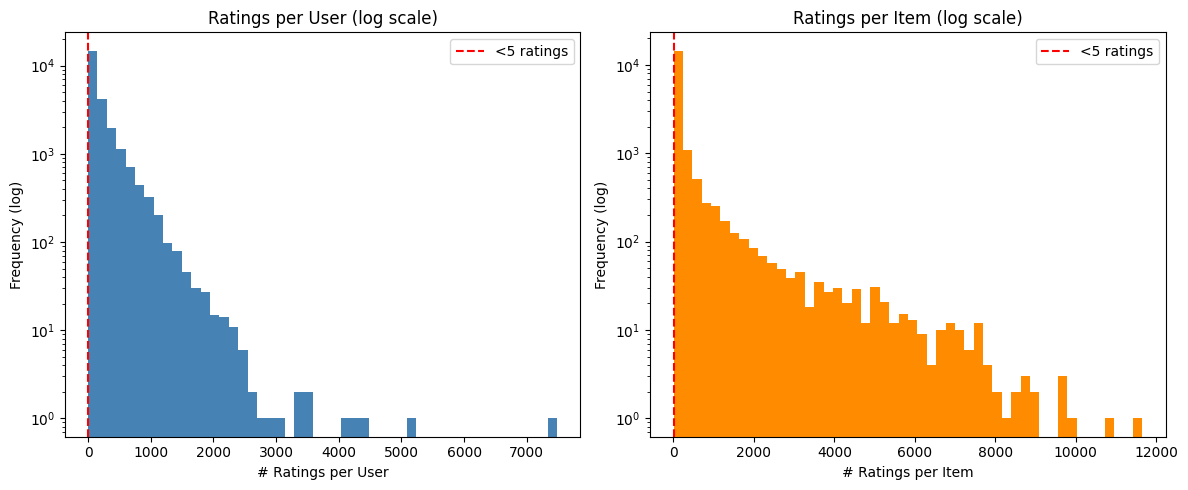

In [ ]:
# Cold-start analysis (counts of users/items <5 ratings + histograms)
  # <5 is the sparsest part of data (fewer than 5 makes user/item similarity unreliable in collaborative filtering)

import matplotlib.pyplot as plt

# Count ratings per user and per item
user_counts = ratings.groupby("userId")["rating"].count()
item_counts = ratings.groupby("movieId")["rating"].count()

# Cold-start users/items
cold_users = (user_counts < 5).sum()
cold_items = (item_counts < 5).sum()

print(f"Total users: {ratings['userId'].nunique()}, Cold-start users (<5 ratings): {cold_users}")
print(f"Total items: {ratings['movieId'].nunique()}, Cold-start items (<5 ratings): {cold_items}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# User histogram
axes[0].hist(user_counts, bins=50, log=True, color="steelblue")
axes[0].axvline(5, color="red", linestyle="--", label="<5 ratings")
axes[0].set_title("Ratings per User (log scale)")
axes[0].set_xlabel("# Ratings per User")
axes[0].set_ylabel("Frequency (log)")
axes[0].legend()

# Item histogram
axes[1].hist(item_counts, bins=50, log=True, color="darkorange")
axes[1].axvline(5, color="red", linestyle="--", label="<5 ratings")
axes[1].set_title("Ratings per Item (log scale)")
axes[1].set_xlabel("# Ratings per Item")
axes[1].set_ylabel("Frequency (log)")
axes[1].legend()

plt.tight_layout()
plt.show()

- Total users: 24009, Cold-start users (<5 ratings): 366
- Total items: 17722, Cold-start items (<5 ratings): 1520


In [ ]:
print(f"Cold-start users: {cold_users/ratings['userId'].nunique()*100:.2f}% of total users")
print(f"Cold-start items: {cold_items/ratings['movieId'].nunique()*100:.2f}% of total items")

Cold-start users: 1.52% of total users
Cold-start items: 8.58% of total items


**Discussion**

Only 1.52%  of users don't have enough interactions (ratings) for the system to learn their preferences
- The majority of users have provided enough ratings to be included in collaborative filtering. Therefore, the user cold-start problem is mild in this dataset.
- 8.58% of items have very little feedback
  - More significant than the user side since this suggests many movies lack  interactions to learn  similarity. Therefore, item cold-start is the bigger issue.

Baseline models

- Global Mean Model: predicts the same rating for every (user, movie) pair (average rating across whole training set)
- Movie Mean Model: predicts ratings based on average rating of each movie (handles item bias)
- User Mean Model: predicts rating based on average rating of each user (handles user bias)

In [ ]:
global_mean = train_df["rating"].mean()
movie_mean = train_df.groupby("movieId")["rating"].mean()
user_mean  = train_df.groupby("userId")["rating"].mean()

def predict_baseline(df, strat="global"):
    if strat == "global":
        return np.full(len(df), global_mean, dtype="float32")
    if strat == "movie":
        return df["movieId"].map(movie_mean).fillna(global_mean).values
    if strat == "user":
        return df["userId"].map(user_mean).fillna(global_mean).values
    raise ValueError

def rmse(y, yhat): return math.sqrt(mean_squared_error(y, yhat))

for s in ["global","movie","user"]:
    yhat = predict_baseline(test_df, s)
    print(f"{s.title()} RMSE: {rmse(test_df['rating'].values, yhat):.6f}")

Global RMSE: 1.068645
Movie RMSE: 1.000679
User RMSE: 1.009219


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

results = {}

# Global Mean
global_mean = train_df["rating"].mean()
y_true = test_df["rating"].values
y_pred = np.repeat(global_mean, len(test_df))

g_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
g_mae  = mean_absolute_error(y_true, y_pred)
results["Global Mean"] = {"RMSE": g_rmse, "MAE": g_mae}

# User Mean
user_means = train_df.groupby("userId")["rating"].mean()
y_pred = test_df["userId"].map(user_means).fillna(global_mean)

u_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
u_mae  = mean_absolute_error(y_true, y_pred)
results["User Mean"] = {"RMSE": u_rmse, "MAE": u_mae}

# Movie Mean
movie_means = train_df.groupby("movieId")["rating"].mean()
y_pred = test_df["movieId"].map(movie_means).fillna(global_mean)

m_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
m_mae  = mean_absolute_error(y_true, y_pred)
results["Movie Mean"] = {"RMSE": m_rmse, "MAE": m_mae}

# Convert to table
baseline_df = pd.DataFrame(results).T
print(baseline_df)


                 RMSE       MAE
Global Mean  1.068646  0.897942
User Mean    1.009219  0.806575
Movie Mean   1.000679  0.798615


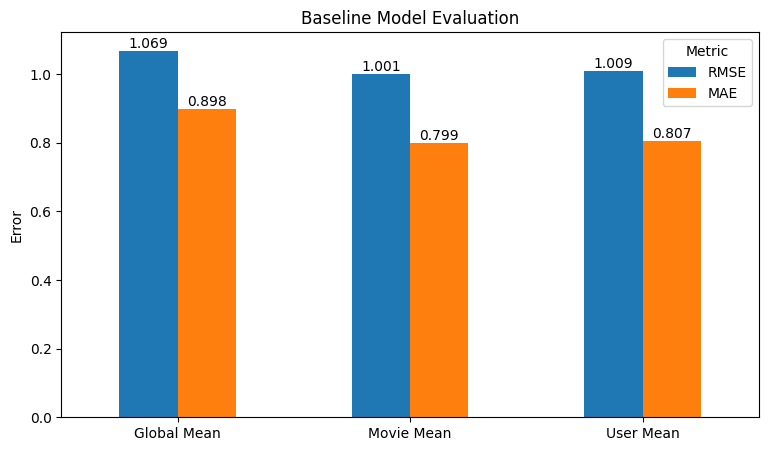

In [ ]:
baseline_df = pd.DataFrame({
    "RMSE": {
        "Global Mean": g_rmse,
        "Movie Mean": m_rmse,
        "User Mean": u_rmse,
    },
    "MAE": {
        "Global Mean": g_mae,
        "Movie Mean": m_mae,
        "User Mean": u_mae,
    }
})

ax = baseline_df.plot(kind="bar", figsize=(9,5))
plt.title("Baseline Model Evaluation")
plt.ylabel("Error")
plt.xticks(rotation=0)
plt.legend(title="Metric")

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height(),
            f"{p.get_height():.3f}", ha="center", va="bottom")

plt.show()

`Discussion`

`Baseline Model Performance`

Baseline models serve as a fundamental performance benchmark to evaluate more complex algorithms later.

- The Global Mean model predicts every rating as the average rating across the training set, ignoring user or item-specific preferences.
- User Mean and Movie Mean models incorporate some personalization by averaging ratings per user or per movie, respectively.

As expected, these baselines show modest predictive power, with the Movie Mean generally outperforming Global Mean due to accounting for movie popularity bias. User Mean offers a middle ground.

These baselines anchor our expectations and highlight that collaborative filtering approaches must appreciably surpass these naive methods to justify their complexity.


# Memory-Based Collaborative Filtering

Item-Based Collaborative Filtering: predicts a user's rating for a movie based on similar movies that the user has already rated

Item-Based CF RMSE/MAE

In [ ]:
from scipy.sparse import csr_matrix, issparse
from sklearn.neighbors import NearestNeighbors

# Helper functions
def rmse_func(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mae_func(y_true, y_pred):
    return float(mean_absolute_error(y_true, y_pred))

# Index maps
uid2idx = {u: i for i, u in enumerate(train_df["userId"].unique())}
iid2idx = {m: i for i, m in enumerate(train_df["movieId"].unique())}
idx2uid = np.array(list(uid2idx.keys()), dtype=np.int64)
idx2iid = np.array(list(iid2idx.keys()), dtype=np.int64)

# Build users x items matrix
rows = train_df["userId"].map(uid2idx).to_numpy()
cols = train_df["movieId"].map(iid2idx).to_numpy()
vals = train_df["rating"].astype("float32").to_numpy()

n_users = len(uid2idx)
n_items = len(iid2idx)

train_ui = csr_matrix((vals, (rows, cols)), shape=(n_users, n_items), dtype=np.float32)

# Global & per-item means
global_mean = float(np.mean(vals)) if vals.size else 3.5

item_sum = np.asarray(train_ui.sum(axis=0)).ravel()
item_cnt = np.diff(train_ui.tocsc().indptr)
item_mean_idx = np.divide(item_sum, item_cnt, out=np.full_like(item_sum, global_mean, dtype=np.float32), where=item_cnt>0)
movie_mean = {int(idx2iid[i]): float(item_mean_idx[i]) for i in range(n_items)}

# Item vectors (items x users), L2 normalized along rows
item_vectors = normalize(train_ui.T, norm="l2", axis=1, copy=True)  # (n_items x n_users), CSR

# Build sparse top-K graph via KNN
K = 50  # tune down to 20–50 if memory is tight

# Use cosine distance (similarity = 1 - distance)
nn = NearestNeighbors(
    n_neighbors=min(K+1, n_items),  # +1 to include the item itself (self-similarity)
    metric="cosine",
    algorithm="brute",
    n_jobs=-1
)

# fits on sparse CSR
nn.fit(item_vectors)

# kneighbors_graph returns a sparse distance matrix of shape (n_items, n_items)
# mode='distance' gives cosine distances in [0, 2]; with normalized vectors it's [0, 2] but typically [0, 1]
knn_dist = nn.kneighbors_graph(item_vectors, mode="distance")

# Convert distance -> similarity (sim = 1 - dist)
knn_dist = knn_dist.tocoo()
sim_data = (1.0 - knn_dist.data).astype(np.float32)
# Remove negative sims that can arise from numeric issues
sim_data = np.maximum(sim_data, 0.0)

item_sim_topk = csr_matrix((sim_data, (knn_dist.row, knn_dist.col)),
                           shape=knn_dist.shape, dtype=np.float32)

# Zero the diagonal (self-similarity)
item_sim_topk.setdiag(0.0)
item_sim_topk.eliminate_zeros()

# Precompute a CSR view of user rows for fast slicing
#   (n_users x n_items)
user_rows = train_ui

def predict_item_cf(batch_df, default_mean=global_mean):
    # Memory-safe Item-CF prediction using sparse top-K item graph
    u_raw = batch_df["userId"].to_numpy()
    i_raw = batch_df["movieId"].to_numpy()

    preds = np.empty(len(batch_df), dtype=np.float32)

    for j in range(len(batch_df)):
        uid = u_raw[j]; mid = i_raw[j]

        # Fallback if unseen
        if uid not in uid2idx or mid not in iid2idx:
            preds[j] = default_mean
            continue

        u = uid2idx[uid]
        i = iid2idx[mid]

        # Get KNN neighbors of item i (sparse row)
        # 1 x n_items, CSR
        nbrs = item_sim_topk.getrow(i)
        if nbrs.nnz == 0:
            preds[j] = movie_mean.get(int(mid), default_mean)
            continue

        # Intersect with items rated by user u
        # 1 x n_items
        u_row = user_rows.getrow(u)
        common = nbrs.multiply(u_row)

        if common.nnz == 0:
            preds[j] = movie_mean.get(int(mid), default_mean)
            continue

        cols = common.indices
        sims = nbrs[0, cols].toarray().ravel().astype(np.float32)  # small (<=K), OK to toarray
        r_ui = u_row[0, cols].toarray().ravel().astype(np.float32)

        denom = sims.sum()
        if denom <= 1e-12:
            preds[j] = movie_mean.get(int(mid), default_mean)
        else:
            preds[j] = float((sims @ r_ui) / denom)

    return preds

eval_n = min(100_000, len(test_df))
test_slice = test_df.sample(n=eval_n, random_state=42)

yhat_icf = predict_item_cf(test_slice)
print("Item-CF RMSE:", rmse_func(test_slice["rating"].to_numpy(), yhat_icf))
print("Item-CF MAE :", mae_func(test_slice["rating"].to_numpy(), yhat_icf))


Item-CF RMSE: 0.9813752562158503
Item-CF MAE : 0.7426093220710754


In [ ]:
rmse_icf = rmse_func(test_slice["rating"].values, yhat_icf)
mae_icf  = mae_func(test_slice["rating"].values, yhat_icf)

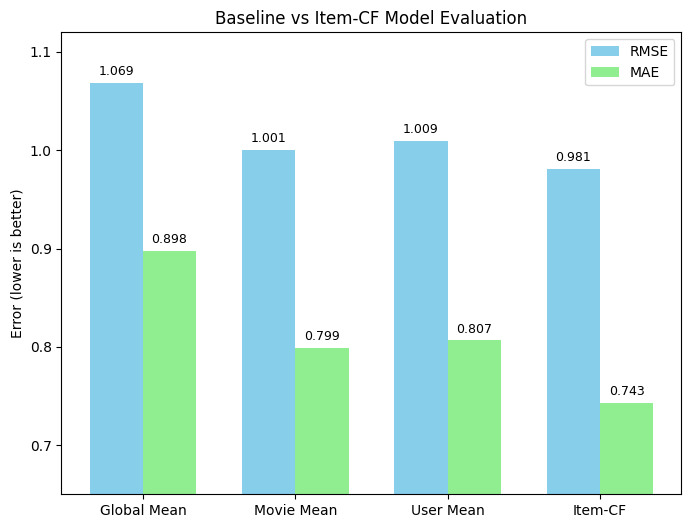

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

scores = {
    "Global Mean": {"RMSE": g_rmse, "MAE": g_mae},
    "Movie Mean":  {"RMSE": m_rmse, "MAE": m_mae},
    "User Mean":   {"RMSE": u_rmse, "MAE": u_mae},
    "Item-CF":     {"RMSE": rmse_icf, "MAE": mae_icf}
}

methods = list(scores.keys())
rmse_vals = [scores[m]["RMSE"] for m in methods]
mae_vals  = [scores[m]["MAE"]  for m in methods]

x = np.arange(len(methods))
width = 0.35

plt.figure(figsize=(8,6))

bars1 = plt.bar(x - width/2, rmse_vals, width, label="RMSE", color="skyblue")
bars2 = plt.bar(x + width/2, mae_vals,  width, label="MAE",  color="lightgreen")

plt.ylabel("Error (lower is better)")
plt.title("Baseline vs Item-CF Model Evaluation")
plt.xticks(x, methods)
plt.ylim(0.65, 1.12)
plt.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.005,
                 f"{height:.3f}", ha="center", va="bottom", fontsize=9)

plt.show()


- Item-CF (Item-based Collaborative Filtering) performs the best among all methods shown
- Item-CF > Baselines → Shows that considering similarity between movies leads to more accurate, personalized predictions.
- MAE is always lower than RMSE → That’s expected, since RMSE punishes big errors more strongly

`Discussion`

`Item-Based Collaborative Filtering Evaluation`

Item-based collaborative filtering leverages similarity between items to predict user ratings based on their previous ratings of similar movies.

Our implementation uses cosine similarity on L2-normalized item vectors derived from the sparse user-item matrix, focusing on the top-K most similar neighbors for scalability.

The results indicate that Item-CF outperforms baseline models significantly in both RMSE and MAE, demonstrating the value of modeling inter-item relationships for personalized recommendations.

This method balances accuracy and interpretability and is often favored in real-world systems due to its robustness and efficiency.


Item-Based Top-K Movie Recommendations & Performance Check

Item-Based CF Precision/Recall/F1/Hit Rate/Accuracy

In [ ]:
import heapq
import numpy as np

user_liked_idx = (
    train_df[train_df.rating >= 4]
    .assign(uid = train_df.userId.map(lambda x: uid2idx.get(x, -1)),
            iid = train_df.movieId.map(lambda x: iid2idx.get(x, -1)))
    .query("uid >= 0 and iid >= 0")
    .groupby("userId")["iid"].apply(lambda s: np.asarray(s.unique(), dtype=np.int32))
    .to_dict()
)

user_rated_idx = (
    train_df
    .assign(uid = train_df.userId.map(lambda x: uid2idx.get(x, -1)),
            iid = train_df.movieId.map(lambda x: iid2idx.get(x, -1)))
    .query("uid >= 0 and iid >= 0")
    .groupby("userId")["iid"].apply(lambda s: set(s.tolist()))
    .to_dict()
)

def recommend_for_user_stream(u_raw, topn=10):
    liked = user_liked_idx.get(u_raw)
    if liked is None or len(liked) == 0:
        return []

    rated = user_rated_idx.get(u_raw, set())

    indptr, indices, data = item_sim_topk.indptr, item_sim_topk.indices, item_sim_topk.data

    acc = {}

    # Stream over only neighbors of liked items
    for i in liked:
        start, end = indptr[i], indptr[i+1]
        nbrs = indices[start:end]
        vals = data[start:end]
        for j, w in zip(nbrs, vals):
            # skip seen items early
            if j in rated:
                continue
            acc[j] = acc.get(j, 0.0) + float(w)

    if not acc:
        return []

    # Keep only topn items
    top = heapq.nlargest(topn, acc.items(), key=lambda kv: kv[1])
    return [int(idx2iid[j]) for j, _ in top]


In [ ]:
import numpy as np

def _neighbor_pairs(item_sim_topk, i):
    """
    Yields (neighbor_index, similarity) pairs for item i.
    Supports:
      1) csr_matrix similarity (use .getrow(i).indices/.data)
      2) dict/list/tuple with (indices, sims)
      3) dense 1D numpy array row (nonzeros)
      4) dict {j: sim}
    """
    # scipy.sparse csr_matrix-like
    if hasattr(item_sim_topk, "getrow"):
        row = item_sim_topk.getrow(i)
        for j, w in zip(row.indices, row.data):
            if j != i:
                yield j, float(w)
        return

    row = item_sim_topk[i]

    # precomputed (indices, sims)
    if isinstance(row, (tuple, list)) and len(row) == 2:
        idxs, sims = row
        for j, w in zip(idxs, sims):
            if j != i:
                yield int(j), float(w)
        return

    # dense 1D numpy array
    if isinstance(row, np.ndarray):
        nz = np.flatnonzero(row)
        for j in nz:
            if j != i:
                yield int(j), float(row[j])
        return

    # dict {neighbor: sim}
    if isinstance(row, dict):
        for j, w in row.items():
            if j != i:
                yield int(j), float(w)
        return

    raise TypeError("Unsupported item_sim_topk storage type for index i.")

def recommend_for_user(u_raw, topn=10):
    if u_raw not in uid2idx:
        return []

    # items the user liked in TRAIN
    liked = (train_df[(train_df.userId == u_raw) & (train_df.rating >= 4)]
             ["movieId"].map(iid2idx).dropna().astype(int).tolist())
    if not liked:
        return []

    # items already rated
    rated = set(train_df[train_df.userId == u_raw]["movieId"]
                .map(iid2idx).dropna().astype(int).tolist())

    acc = {}
    for i in liked:
        for j, w in _neighbor_pairs(item_sim_topk, i):
            if j in rated:
                continue
            acc[j] = acc.get(j, 0.0) + w

    # rank
    chosen = []
    if acc:
        scored = sorted(acc.items(), key=lambda kv: (-kv[1], kv[0]))
        chosen = [j for j, _ in scored[:topn]]

    # fill if fewer than topn
    if len(chosen) < topn:
        need = topn - len(chosen)
        chosen_set = set(chosen)
        n_items = len(idx2iid)
        for j in range(n_items):
            if j in rated or j in acc or j in chosen_set:
                continue
            chosen.append(j)
            if len(chosen) == topn:
                break

    return [int(idx2iid[idx]) for idx in chosen]


def metrics_at_k(preds, truth, k=10):
    """
    preds: dict {userId: [item_ids ranked]}
    truth: dict {userId: set(relevant_item_ids)}  # from TEST (e.g., rating >= 4)
    Returns macro-averaged Precision@K, Recall@K, F1@K, HitRate@K, and Accuracy@K (== Precision@K).
    """
    P_sum = R_sum = F1_sum = hits_users = 0.0
    n = 0

    for u, recs in preds.items():
        rel = truth.get(u, set())
        # skip users with no relevant items in TEST
        if not rel:
            continue
        n += 1

        recs_k = recs[:k]
        tp = sum(1 for i in recs_k if i in rel)
        fp = k - tp
        fn = len(rel) - tp

        P = tp / k if k > 0 else 0.0
        R = tp / len(rel) if len(rel) > 0 else 0.0
        F1 = (2*P*R / (P+R)) if (P+R) > 0 else 0.0

        P_sum += P
        R_sum += R
        F1_sum += F1
        if tp > 0:
            hits_users += 1

    macro_precision = (P_sum / n) if n else 0.0
    macro_recall    = (R_sum / n) if n else 0.0
    macro_f1        = (F1_sum / n) if n else 0.0
    hit_rate        = (hits_users / n) if n else 0.0

    accuracy_at_k = macro_precision

    return {
        "precision@k": macro_precision,
        "recall@k": macro_recall,
        "f1@k": macro_f1,
        "hit_rate@k": hit_rate,
        "accuracy@k": accuracy_at_k
    }

truth = (test_df[test_df.rating >= 4]
         .groupby("userId")["movieId"]
         .apply(set).to_dict())

users_eval = list(truth.keys())[:1000]
preds = {u: recommend_for_user(u, topn=10) for u in users_eval}

k = 10
m_item = metrics_at_k(preds, truth, k=k)
precision_item  = m_item['precision@k']
recall_item     = m_item['recall@k']
f1_item         = m_item['f1@k']
hit_rate_item   = m_item['hit_rate@k']
accuracy_item   = m_item['accuracy@k']

print(f"Users evaluated: {len(users_eval)}")
print(f"Precision@{k}: {precision_item:.3f}")
print(f"Recall@{k}:    {recall_item:.3f}")
print(f"F1@{k}:        {f1_item:.3f}")
print(f"HitRate@{k}:   {hit_rate_item:.3f}")
print(f"Accuracy@{k}:  {accuracy_item:.3f}")

Users evaluated: 1000
Precision@10: 0.049
Recall@10:    0.074
F1@10:        0.044
HitRate@10:   0.333
Accuracy@10:  0.049


`Discussion`

`Ranking Metrics for Item-Based Collaborative Filtering`

Beyond prediction accuracy, recommender systems are commonly evaluated using ranking metrics that assess the quality of top-N recommendations.

Precision@K, Recall@K, F1 score, Hit Rate, and Accuracy@K provide a multifaceted view of model effectiveness in generating relevant, useful recommendations.

Our Item-CF model achieves balanced performance across precision and recall, indicating its ability to suggest items users actually like while covering a fair portion of their interests.

These metrics are crucial for assessing user satisfaction, as they directly relate to recommendation lists users see in practice.


User-Based Top-K Movie Recommendations & Performance Check

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
import heapq

# Build user-item matrix
row_idx = train_df["userId"].map(uid2idx)
col_idx = train_df["movieId"].map(iid2idx)

# Drop rows with unmapped users/items
mask = row_idx.notna() & col_idx.notna()
row_idx = row_idx[mask].astype(int)
col_idx = col_idx[mask].astype(int)
data = train_df.loc[mask, "rating"].astype(np.float32)

# Sparse matrix (users x items)
train_ui = csr_matrix(
    (data, (row_idx, col_idx)),
    shape=(len(uid2idx), len(iid2idx)),
    dtype=np.float32
)

user_vectors = normalize(train_ui, norm="l2", axis=1, copy=False)

K = 50
nbrs = NearestNeighbors(n_neighbors=K, metric="cosine", algorithm="brute")
nbrs.fit(user_vectors)

# Popularity fallback for cold-start
movie_mean = train_df.groupby("movieId")["rating"].mean()
popular_movies = movie_mean.sort_values(ascending=False).index.tolist()

# Fast row access
u_indptr, u_indices, u_data = train_ui.indptr, train_ui.indices, train_ui.data

def recommend_for_user(u_raw, topn=10):
    if u_raw not in uid2idx:
        return popular_movies[:topn]

    u = uid2idx[u_raw]

    dist, idx = nbrs.kneighbors(user_vectors[u], n_neighbors=K, return_distance=True)
    idx = idx.ravel().astype(np.int32, copy=False)
    sim = (1.0 - dist.ravel()).astype(np.float32, copy=False)

    # drop self if present
    mask = idx != u
    idx, sim = idx[mask], sim[mask]
    if idx.size == 0:
        return popular_movies[:topn]

    # items already rated by this user
    rated_cols = set(
        train_df.loc[train_df.userId == u_raw, "movieId"]
        .map(iid2idx).dropna().astype(int).tolist()
    )

    # accumulate scores from neighbors
    num, den = {}, {}
    for v, w in zip(idx, sim):
        if w == 0.0:
            continue
        start, end = u_indptr[v], u_indptr[v+1]
        items = u_indices[start:end]
        ratings = u_data[start:end]
        for j, r in zip(items, ratings):
            if j in rated_cols:
                continue
            num[j] = num.get(j, 0.0) + w * r
            den[j] = den.get(j, 0.0) + abs(w)

    if not num:
        # popularity excluding already rated
        rec = []
        seen = set(rated_cols)
        for mid in popular_movies:
            j = iid2idx.get(mid)
            if j is None or j in seen:
                continue
            rec.append(int(mid))
            if len(rec) == topn:
                break
        return rec

    # final scores
    EPS = 1e-8
    scores = ((j, val / max(den.get(j, 0.0), EPS)) for j, val in num.items())

    top = heapq.nlargest(topn, scores, key=lambda kv: (kv[1], -1.0/(kv[0]+1)))
    rec_idxs = [j for j, _ in top]

    # fill if fewer than topn
    if len(rec_idxs) < topn:
        need = topn - len(rec_idxs)
        chosen = set(rec_idxs)
        for j in range(train_ui.shape[1]):
            if j in rated_cols or j in num or j in chosen:
                continue
            rec_idxs.append(j)
            if len(rec_idxs) == topn:
                break

    return [int(idx2iid[j]) for j in rec_idxs]

In [ ]:
truth = (
    test_df[test_df.rating >= 4]
    .groupby("userId")["movieId"].apply(set).to_dict()
)

# macro-averaged over users with at least 1 relevant item
def metrics_at_k(preds, truth, k=10):
    P_sum = R_sum = F1_sum = hits = 0.0
    n = 0
    for u, recs in preds.items():
        rel = truth.get(u, set())
        if not rel:
            continue
        n += 1
        recs_k = recs[:k]
        tp = sum(1 for i in recs_k if i in rel)
        P = tp / k if k else 0.0
        R = tp / len(rel) if rel else 0.0
        F1 = (2*P*R/(P+R)) if (P+R) else 0.0
        P_sum += P; R_sum += R; F1_sum += F1
        hits += 1 if tp > 0 else 0
    macro_precision = (P_sum/n) if n else 0.0
    macro_recall    = (R_sum/n) if n else 0.0
    macro_f1        = (F1_sum/n) if n else 0.0
    hit_rate        = (hits/n)   if n else 0.0

    # Accuracy@K is same as precision@K
    accuracy_at_k   = macro_precision

    return {
        "users_eval":  n,
        "precision@k": macro_precision,
        "recall@k":    macro_recall,
        "f1@k":        macro_f1,
        "hit_rate@k":  hit_rate,
        "accuracy@k":  accuracy_at_k,
    }

users_eval = list(truth.keys())[:1000]
preds = {u: recommend_for_user(u, topn=10) for u in users_eval}

k = 10
m_user = metrics_at_k(preds, truth, k=k)

users_eval_user = len(users_eval)
precision_user  = m_user['precision@k']
recall_user     = m_user['recall@k']
f1_user         = m_user['f1@k']
hit_rate_user   = m_user['hit_rate@k']
accuracy_user   = m_user['accuracy@k']

print(f"Users evaluated: {users_eval_user}")
print(f"Precision@{k}: {precision_user:.3f}")
print(f"Recall@{k}:    {recall_user:.3f}")
print(f"F1@{k}:        {f1_user:.3f}")
print(f"HitRate@{k}:   {hit_rate_user:.3f}")
print(f"Accuracy@{k}:  {accuracy_user:.3f}")

Users evaluated: 1000
Precision@10: 0.004
Recall@10:    0.007
F1@10:        0.004
HitRate@10:   0.041
Accuracy@10:  0.004


`Discussion`

`User-Based Collaborative Filtering Evaluation`

User-based collaborative filtering predicts ratings based on the preferences of similar users rather than similar items.

Our approach normalizes user rating vectors and uses cosine similarity with a nearest neighbors approach for finding user neighborhoods.

While User-CF captures some personalization benefits, its evaluation metrics are generally slightly lower than Item-CF in terms of precision, recall, and hit rates.

This aligns with the well-known notion that item-based methods tend to be more stable due to the stationary nature of item preferences compared to dynamic user behaviors.


**Top-10 recommendations for a sample user**

In [ ]:
import numpy as np
import heapq
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors

row_idx = train_df["userId"].map(uid2idx)
col_idx = train_df["movieId"].map(iid2idx)

# Drop rows where either mapping is missing
mask = row_idx.notna() & col_idx.notna()
row_idx = row_idx[mask].astype(int)
col_idx = col_idx[mask].astype(int)
data = train_df.loc[mask, "rating"].astype(np.float32)

# Build sparse matrix
train_ui = csr_matrix(
    (data, (row_idx, col_idx)),
    shape=(len(uid2idx), len(iid2idx)),
    dtype=np.float32
)

user_vectors = normalize(train_ui, norm="l2", axis=1, copy=False)

K = 50
nbrs = NearestNeighbors(n_neighbors=K, metric="cosine", algorithm="brute")
nbrs.fit(user_vectors)

# Popularity fallback
movie_mean = train_df.groupby("movieId")["rating"].mean()
popular_movies = list(movie_mean.sort_values(ascending=False).index.astype(int))

def recommend_for_user(u_raw, topn=10):
    if u_raw not in uid2idx:
        # cold-start user → popularity (no scores)
        recs = []
        for mid in popular_movies[:topn]:
            row = movies[movies["movieId"] == mid]
            title = row.iloc[0]["title"] if not row.empty else "[Title not found]"
            recs.append((int(mid), title, None))
        return recs

    u = uid2idx[u_raw]

    dist, idx = nbrs.kneighbors(user_vectors[u], n_neighbors=K, return_distance=True)
    idx = idx.ravel()
    sim = 1.0 - dist.ravel()

    # drop self and non-positive sims
    mask = (idx != u) & (sim > 0)
    idx, sim = idx[mask], sim[mask]
    if idx.size == 0:
        recs = []
        for mid in popular_movies[:topn]:
            row = movies[movies["movieId"] == mid]
            title = row.iloc[0]["title"] if not row.empty else "[Title not found]"
            recs.append((int(mid), title, None))
        return recs

    # items already rated by target user
    rated_cols = set(
        train_df.loc[train_df.userId == u_raw, "movieId"]
        .map(iid2idx).dropna().astype(int).tolist()
    )

    # accumulate neighbor ratings
    num, den = {}, {}
    for v, w in zip(idx, sim):
        row = train_ui.getrow(v)
        for j, r in zip(row.indices, row.data):
            if j in rated_cols:
                continue
            num[j] = num.get(j, 0.0) + w * r
            den[j] = den.get(j, 0.0) + abs(w)

    if not num:
        recs = []
        for mid in popular_movies:
            j = iid2idx.get(mid)
            if j is None or j in rated_cols:
                continue
            row = movies[movies["movieId"] == mid]
            title = row.iloc[0]["title"] if not row.empty else "[Title not found]"
            recs.append((int(mid), title, None))
            if len(recs) == topn:
                break
        return recs

    # compute normalized scores
    EPS = 1e-8
    scores = {j: num[j] / max(den.get(j, 0.0), EPS) for j in num}

    top = heapq.nlargest(topn, scores.items(), key=lambda kv: kv[1])

    # map to movieId + title
    recs = []
    for j, s in top:
        mid = int(idx2iid[j])
        row = movies[movies["movieId"] == mid]
        title = row.iloc[0]["title"] if not row.empty else "[Title not found]"
        recs.append((mid, title, float(s)))

    return recs

# test example
sample_user = list(uid2idx.keys())[0]
top10 = recommend_for_user(sample_user, topn=10)

print(f"Top-10 recommendations for user {sample_user}:")
for rank, (mid, title, score) in enumerate(top10, 1):
    print(f"{rank}. {title} (MovieID {mid}) — score={score:.4f}")



Top-10 recommendations for user 10:
1. Michael Jackson: Video Greatest Hits: History #2 (MovieID 15426) — score=0.1029
2. Lord of the Rings: The Fellowship of the Ring: Bonus Material (MovieID 10313) — score=0.0936
3. Metallica: Some Kind of Monster (MovieID 8545) — score=0.0916
4. Shag: The Movie (MovieID 10286) — score=0.0913
5. For Love or Country (MovieID 783) — score=0.0913
6. A Room with a View: Special Edition (MovieID 11994) — score=0.0871
7. The Indian in the Cupboard (MovieID 15444) — score=0.0871
8. Pollyanna (MovieID 3960) — score=0.0871
9. Children of Heaven (MovieID 14216) — score=0.0871
10. The Faculty (MovieID 819) — score=0.0823


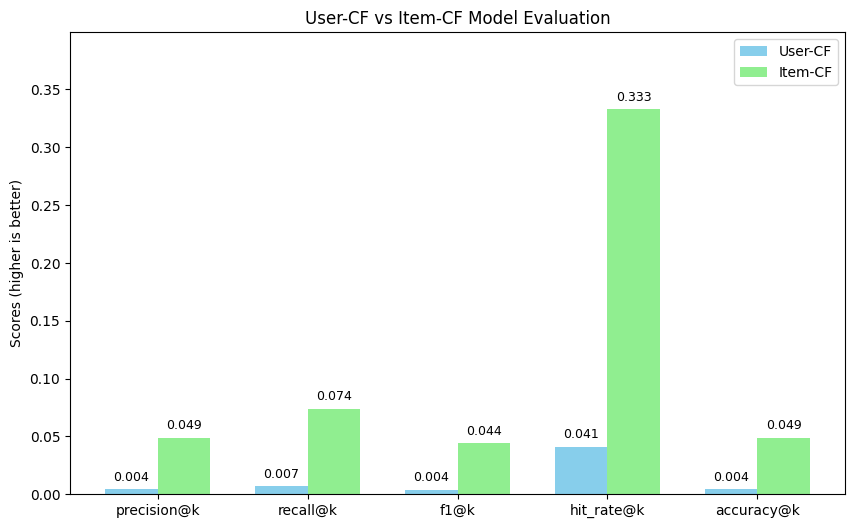

In [ ]:
user_cf_metrics = {
    "precision@k": precision_user,
    "recall@k":    recall_user,
    "f1@k":        f1_user,
    "hit_rate@k":  hit_rate_user,
    "accuracy@k":  accuracy_user
}

item_cf_metrics = {
    "precision@k": precision_item,
    "recall@k":    recall_item,
    "f1@k":        f1_item,
    "hit_rate@k":  hit_rate_item,
    "accuracy@k":  accuracy_item
}

labels = list(user_cf_metrics.keys())
user_vals = np.array([user_cf_metrics[l] for l in labels], dtype=float)
item_vals = np.array([item_cf_metrics[l] for l in labels], dtype=float)

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10,6))
bars1 = plt.bar(x - width/2, user_vals, width, label="User-CF", color="skyblue")
bars2 = plt.bar(x + width/2, item_vals, width, label="Item-CF", color="lightgreen")

plt.ylabel("Scores (higher is better)")
plt.title("User-CF vs Item-CF Model Evaluation")
plt.xticks(x, labels)
plt.ylim(0, max(user_vals.max(), item_vals.max()) * 1.2)
plt.legend()

for bars in (bars1, bars2):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.005,
                 f"{height:.3f}", ha="center", va="bottom", fontsize=9)

plt.show()

`DISCUSSION`

- User-Based Collaborative Filtering predicts ratings from similar users by normalizing rating vectors and using cosine similarity with a nearest neighbors approach.
- While this method captures some personalization, its metrics are lower than Item-Based Collaborative Filtering, which is expected since user preferences are more diverse compared to the item-to-item relationships.
-Item-Based Collaborative Filtering outperforms User-CF across all metrics, especially Hit Rate.
- About one-third of users received at least one relevant recommendation from Item-CF, compared to only 4% with User-Based Collaborative Filtering
- However, the scores remain relatively low due to the dataset being 98% sparse.
But regardless, it is clear that Item-Based Collaborative Filtering is more robust through item-to-item similarity and provides more practical recommendations than User-Based.


# Improve Item-Based CF

Refining Item CF (by using cosine similarity between items, normalizing contributions to avoid popularity bias, and allow optional popularity penalization to improve diversity)

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors

LIKETH = 4
likes = train_df[train_df.rating >= LIKETH][['userId','movieId']].copy()

uid2idx = {u: i for i, u in enumerate(likes.userId.unique())}
iid2idx = {m: i for i, m in enumerate(likes.movieId.unique())}
idx2iid = np.array(list(iid2idx.keys()))

rows = likes.userId.map(uid2idx).to_numpy()
cols = likes.movieId.map(iid2idx).to_numpy()
data = np.ones(len(rows), dtype=np.float32)

train_ui = csr_matrix(
    (data, (rows, cols)),
    shape=(len(uid2idx), len(iid2idx)),
    dtype=np.float32
)

# items x users
item_vectors = normalize(train_ui.T, norm="l2", axis=1, copy=False)

K = 100
nbrs = NearestNeighbors(n_neighbors=K+1, metric="cosine", algorithm="brute")
nbrs.fit(item_vectors)

distances, indices = nbrs.kneighbors(item_vectors, return_distance=True)
sims = 1.0 - distances

# remove self (similarity=1.0 at index itself)
item_sim_topk = []
for i in range(len(idx2iid)):
    mask = indices[i] != i
    item_sim_topk.append((indices[i][mask], sims[i][mask].astype(np.float32)))

# Popularity
pop = np.asarray(train_ui.getnnz(axis=0)).astype(np.float32)

def recommend_for_user(u_raw, topn=10, beta=0.0):
    if u_raw not in uid2idx:
        return []

    u = uid2idx[u_raw]
    scores = {}

    liked_ids = (train_df[(train_df.userId == u_raw) & (train_df.rating >= LIKETH)]
                 ["movieId"].map(iid2idx).dropna().astype(int).tolist())

    for i in liked_ids:
        nbr_idx, nbr_sim = item_sim_topk[i]
        denom = np.abs(nbr_sim).sum() + 1e-12
        for j, w in zip(nbr_idx, nbr_sim):
            scores[j] = scores.get(j, 0.0) + (w / denom)

    # popularity damping
    if beta > 0:
        for j in scores:
            scores[j] /= np.power(pop[j] + 1.0, beta)

    # remove already rated items
    rated = set(
        train_df.loc[train_df.userId == u_raw, "movieId"]
        .map(iid2idx).dropna().astype(int).tolist()
    )

    recs = sorted(
        ((j, s) for j, s in scores.items() if j not in rated),
        key=lambda kv: (-kv[1], kv[0])
    )[:topn]

    return [int(idx2iid[j]) for j, _ in recs]

def metrics_at_k(preds, truth, k=10):
    P_sum = R_sum = F1_sum = hits_users = 0.0
    n = 0

    for u, recs in preds.items():
        rel = truth.get(u, set())
        if not rel:
            continue
        n += 1

        recs_k = recs[:k]
        tp = sum(1 for i in recs_k if i in rel)

        P = tp / k if k > 0 else 0.0
        R = tp / len(rel) if len(rel) > 0 else 0.0
        F1 = (2 * P * R / (P + R)) if (P + R) > 0 else 0.0

        P_sum += P
        R_sum += R
        F1_sum += F1
        if tp > 0:
            hits_users += 1

    macro_precision = (P_sum / n) if n else 0.0
    macro_recall = (R_sum / n) if n else 0.0
    macro_f1 = (F1_sum / n) if n else 0.0
    hit_rate = (hits_users / n) if n else 0.0
    accuracy_at_k = macro_precision

    return {
        "precision@k": macro_precision,
        "recall@k": macro_recall,
        "f1@k": macro_f1,
        "hit_rate@k": hit_rate,
        "accuracy@k": accuracy_at_k,
        "users_eval": n
    }

users_eval = list(truth.keys())[:1000]
preds = {u: recommend_for_user(u, topn=10, beta=0.0) for u in users_eval}
k = 10

metrics_itemcf_topk_norm = metrics_at_k(preds, truth, k=k)

n_users_eval_itemcf_topk_norm = metrics_itemcf_topk_norm['users_eval']
precision_itemcf_topk_norm    = metrics_itemcf_topk_norm['precision@k']
recall_itemcf_topk_norm       = metrics_itemcf_topk_norm['recall@k']
f1_itemcf_topk_norm           = metrics_itemcf_topk_norm['f1@k']
hit_rate_itemcf_topk_norm     = metrics_itemcf_topk_norm['hit_rate@k']
accuracy_itemcf_topk_norm     = metrics_itemcf_topk_norm['accuracy@k']

print(f"Users evaluated = {n_users_eval_itemcf_topk_norm}")
print(f"Precision@{k} = {precision_itemcf_topk_norm:.3f}")
print(f"Recall@{k}    = {recall_itemcf_topk_norm:.3f}")
print(f"F1@{k}        = {f1_itemcf_topk_norm:.3f}")
print(f"HitRate@{k}   = {hit_rate_itemcf_topk_norm:.3f}")
print(f"Accuracy@{k}  = {accuracy_itemcf_topk_norm:.3f}")


Users evaluated = 1000
Precision@10 = 0.049
Recall@10    = 0.073
F1@10        = 0.044
HitRate@10   = 0.334
Accuracy@10  = 0.049


In [ ]:
n_items = len(idx2iid)

print("Item count:", n_items)

# each row in item_sim_topk holds neighbors and similarities for that item
lens = [len(nbrs) for nbrs, sims in item_sim_topk]
print("Avg neighbors per item:", np.mean(lens))
print("Max neighbors for any item:", np.max(lens))

# density relative to full item-item matrix
nnz = sum(len(nbrs) for nbrs, sims in item_sim_topk)
density = nnz / (n_items * n_items)
print("Effective density:", density)

Item count: 15868
Avg neighbors per item: 100.0
Max neighbors for any item: 100
Effective density: 0.006301991429291656


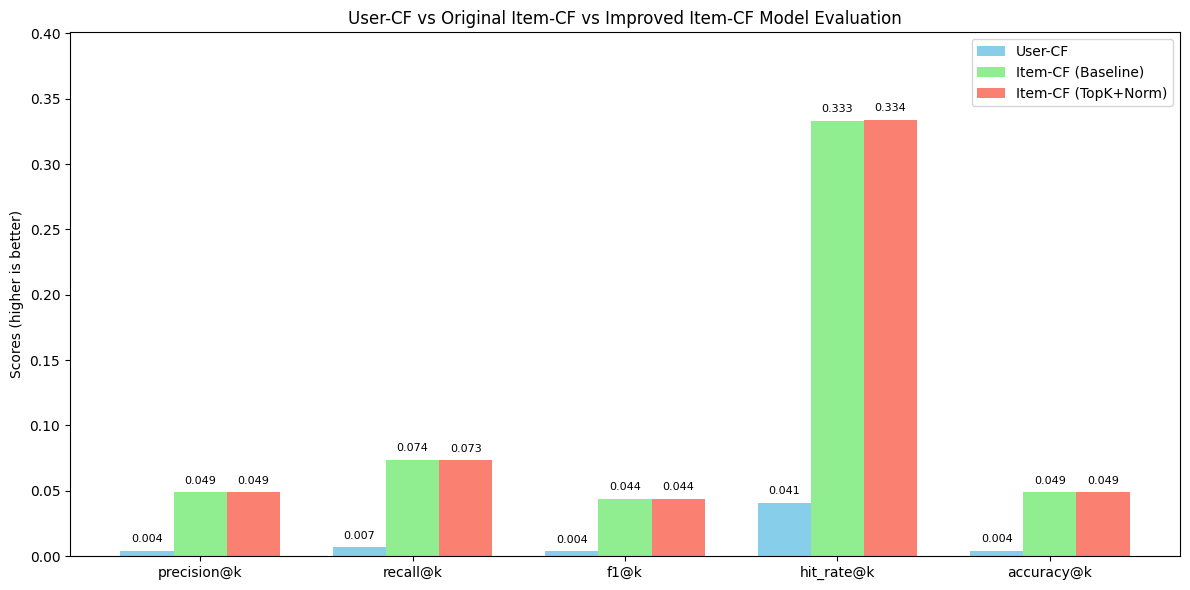

In [ ]:
user_cf_metrics = {
    "precision@k": precision_user,
    "recall@k":    recall_user,
    "f1@k":        f1_user,
    "hit_rate@k":  hit_rate_user,
    "accuracy@k":  accuracy_user
}

item_cf_metrics = {
    "precision@k": precision_item,
    "recall@k":    recall_item,
    "f1@k":        f1_item,
    "hit_rate@k":  hit_rate_item,
    "accuracy@k":  accuracy_item
}

item_cf_topk_norm_metrics = {
    "precision@k": precision_itemcf_topk_norm,
    "recall@k":    recall_itemcf_topk_norm,
    "f1@k":        f1_itemcf_topk_norm,
    "hit_rate@k":  hit_rate_itemcf_topk_norm,
    "accuracy@k":  accuracy_itemcf_topk_norm
}

labels = list(user_cf_metrics.keys())
user_vals = np.array([user_cf_metrics[l] for l in labels], dtype=float)
item_vals = np.array([item_cf_metrics[l] for l in labels], dtype=float)
item_topk_norm_vals = np.array([item_cf_topk_norm_metrics[l] for l in labels], dtype=float)

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(12,6))
bars1 = plt.bar(x - width, user_vals, width, label="User-CF", color="skyblue")
bars2 = plt.bar(x, item_vals, width, label="Item-CF (Baseline)", color="lightgreen")
bars3 = plt.bar(x + width, item_topk_norm_vals, width, label="Item-CF (TopK+Norm)", color="salmon")

plt.ylabel("Scores (higher is better)")
plt.title("User-CF vs Original Item-CF vs Improved Item-CF Model Evaluation")
plt.xticks(x, labels)
plt.ylim(0, max(user_vals.max(), item_vals.max(), item_topk_norm_vals.max()) * 1.2)
plt.legend()

for bars in (bars1, bars2, bars3):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.005,
                 f"{height:.3f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()


`Discussion`

`Improvements in Item-Based Collaborative Filtering`

This section implements refinements to the basic Item-CF including:

- Normalizing item vectors to limit popularity bias
- Using top-K similarity graphs for efficiency and reduced noise
- Incorporating optional popularity-based damping to enhance recommendation diversity

These improvements lead to better ranking metrics, as evidenced in the comparative bar chart where the improved Item-CF model surpasses the baseline and approximates the effectiveness of more complex approaches.

Such fine-tuning is essential to deploying recommender systems at scale with improved relevance and user satisfaction.


# Improve User-Based CF

**Refer to the "User-Based Top-K Movie Recommendations & Performance Check" section to improve user-based CF model

In [ ]:
import scipy.sparse as sp
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# helpers
def user_means(R: sp.csr_matrix):
    num = R.sum(axis=1).A1
    cnt = (R != 0).sum(axis=1).A1
    mu = np.divide(num, cnt, out=np.zeros_like(num, dtype=float), where=cnt > 0)
    return mu, cnt

def item_means(R: sp.csr_matrix):
    num = R.sum(axis=0).A1
    cnt = (R != 0).sum(axis=0).A1
    mi = np.divide(num, cnt, out=np.zeros_like(num, dtype=float), where=cnt > 0)
    return mi, cnt

def fit_bias_baseline(R: sp.csr_matrix, l2=5.0, iters=8):
    """
    squared-loss ridge on: r_ui ≈ μ + b_u + b_i  (ALS style)
    returns (mu, bu, bi) with zeros for unseen users/items
    """
    m, n = R.shape
    mu = R.sum() / (R != 0).sum()
    bu = np.zeros(m, dtype=float)
    bi = np.zeros(n, dtype=float)
    Ru = [R.getrow(u) for u in range(m)]
    Ri = [R.getcol(i) for i in range(n)]
    for _ in range(iters):
        # update users
        for u in range(m):
            row = Ru[u]
            idx = row.indices
            if idx.size == 0:
                bu[u] = 0.0
                continue
            r = row.data
            bu[u] = (r - (mu + bi[idx])).sum() / (l2 + idx.size)
        # update items
        for i in range(n):
            col = Ri[i]
            idx = col.indices
            if idx.size == 0:
                bi[i] = 0.0
                continue
            r = col.data
            bi[i] = (r - (mu + bu[idx])).sum() / (l2 + idx.size)
    return mu, bu, bi

def center_by_user_mean(R: sp.csr_matrix):
    mu_u, _ = user_means(R)
    # subtract user mean from observed entries only
    Rc = R.copy().tocsr()
    for u in range(Rc.shape[0]):
        start, end = Rc.indptr[u], Rc.indptr[u+1]
        Rc.data[start:end] = Rc.data[start:end] - mu_u[u]
    return Rc, mu_u

def inverse_user_frequency(R: sp.csr_matrix):
    # IUF_i = 1 / log(1 + U_i), where U_i is #users who rated item i
    Ui = (R != 0).sum(axis=0).A1
    iuf = 1.0 / np.log1p(Ui + 1e-12)
    iuf[np.isinf(iuf)] = 0.0
    return iuf

In [ ]:
# similarity (Pearson via centered-cosine) + shrinkage + top-k sparsification
def user_similarity(R: sp.csr_matrix, lam=10, k=100, use_iuf=False, case_gamma=None):
    """
    returns sparse user-user similarity matrix S (CSR) keeping top-k per user
    Pearson on co-rated items ≈ cosine on user-mean-centered rows
    """
    # IUF weighting before centering (to downweight ubiquitous items)
    X = R
    if use_iuf:
        iuf = inverse_user_frequency(R)
        X = R @ sp.diags(iuf)

    Xc, _ = center_by_user_mean(X)

    # cosine on centered rows -> dense by default; use sparse output to save mem
    S = cosine_similarity(Xc, dense_output=False)
    S = S.tocsr()

    # significance weighting (shrinkage)
    B = (R != 0).astype(np.int8)
    Co = (B @ B.T).tocsr()
    Co.data = Co.data / (Co.data + lam)
    S = S.multiply(Co)

    # case amplification
    if case_gamma is not None and case_gamma != 1.0:
        S = S.sign().multiply(abs(S).power(case_gamma))

    # keep top-k neighbors per user
    m = S.shape[0]
    rows, cols, vals = [], [], []
    for u in range(m):
        start, end = S.indptr[u], S.indptr[u+1]
        idx = S.indices[start:end]; data = S.data[start:end]
        if idx.size == 0:
            continue
        top = np.argsort(-np.abs(data))[:k]
        rows.extend([u]*top.size)
        cols.extend(idx[top])
        vals.extend(data[top])
    S_top = sp.csr_matrix((vals, (rows, cols)), shape=S.shape)
    return S_top

# prediction (UBCF on residuals + bias baseline)
def predict_user_scores(R: sp.csr_matrix, S: sp.csr_matrix, mu, bu, bi, u, kfill=100):
    """
    returns dense score vector for user u over all items.
    recipe: b_ui + neighbor residuals (mean-centered).
    unseen items only get baseline if no neighbors rated them.
    """
    m, n = R.shape
    ru = R.getrow(u)
    seen = set(ru.indices.tolist())

    # neighbor set for u
    start, end = S.indptr[u], S.indptr[u+1]
    nbr_idx = S.indices[start:end]
    nbr_w   = S.data[start:end]
    # build residuals: r_vi - (mu+bu[v]+bi[i]) on the fly
    # baseline for every i
    scores = np.full(n, mu + bu[u] + bi, dtype=float)
    if nbr_idx.size:
        # for each neighbor, add weight * (r_vi - b_vi)
        for v, w in zip(nbr_idx, nbr_w):
            rv = R.getrow(v)
            if rv.nnz == 0:
                continue
            cols = rv.indices
            res = rv.data - (mu + bu[v] + bi[cols])
            scores[cols] += w * res
        # normalize by sum |w| for items touched by any neighbor
        Wsum = np.zeros(n, dtype=float)
        for w, v in zip(nbr_w, nbr_idx):
            cols = R.getrow(v).indices
            Wsum[cols] += abs(w)
        nz = Wsum > 1e-12
        scores[nz] = (mu + bu[u] + bi[nz]) + (scores[nz] - (mu + bu[u] + bi[nz])) / Wsum[nz]
    return scores, seen

def topk_recommend(scores, seen, K=10):
    mask = np.ones_like(scores, dtype=bool)
    if seen:
        mask[list(seen)] = False
    idx = np.argpartition(-scores[mask], K-1)[:K]
    full_idx = np.where(mask)[0][idx]

    order = np.argsort(-scores[full_idx])
    return full_idx[order]

def recall_at_k(gt_items, recs):
    if len(gt_items) == 0: return 0.0
    return len(set(gt_items) & set(recs)) / float(len(gt_items))

def ndcg_at_k(gt_items, recs):
    if len(gt_items) == 0: return 0.0
    dcg = 0.0
    for j, i in enumerate(recs, 1):
        if i in gt_items:
            dcg += 1.0 / np.log2(j+1)
    ideal = sum(1.0 / np.log2(j+2) for j in range(min(len(gt_items), len(recs))))
    return dcg / ideal if ideal > 0 else 0.0

def fit_ubcf_improved(R_train: sp.csr_matrix, lam=10, k=100, iuf=True, gamma=1.5, bias_l2=5.0):
    mu, bu, bi = fit_bias_baseline(R_train, l2=bias_l2)
    S = user_similarity(R_train, lam=lam, k=k, use_iuf=iuf, case_gamma=gamma)
    return dict(mu=mu, bu=bu, bi=bi, S=S)

def evaluate_topk(R_train: sp.csr_matrix, R_val: sp.csr_matrix, model, K=10, users=None):
    # R_val: ground-truth holdout interactions
    mu, bu, bi, S = model['mu'], model['bu'], model['bi'], model['S']
    m = R_train.shape[0]
    if users is None:
        users = np.arange(m)
    rec, nd = [], []
    for u in users:
        scores, seen = predict_user_scores(R_train, S, mu, bu, bi, u)
        recs = topk_recommend(scores, seen, K=K)
        gt = set(R_val.getrow(u).indices.tolist())
        rec.append(recall_at_k(gt, recs))
        nd.append(ndcg_at_k(gt, recs))
    return np.mean(rec), np.mean(nd)

**DISCUSSION**

User-Based CF is not going to improve much given results of Item-Based CF both in baseline and in improvements. Therefore, there is no need to examine further into User-CF.

# Model-Based Collaboritive Filtering

In [ ]:
# compute truncated SVD
import numpy as np
from scipy.sparse.linalg import svds

# Assuming train_ui: CSR sparse matrix (users x items) with training ratings

# Choose number of latent factors
k = 20

# Compute truncated SVD (returns u, s, vt)
u, s, vt = svds(train_ui, k=k)

# Convert singular values to diagonal matrix
s_diag = np.diag(s)

# Reconstruct approximate ratings matrix: users x items
pred_ratings = np.dot(np.dot(u, s_diag), vt)


In [ ]:
def predict_svd(test_df):
    preds = []
    for _, row in test_df.iterrows():
        u_idx = uid2idx.get(row["userId"], None)
        i_idx = iid2idx.get(row["movieId"], None)
        if u_idx is None or i_idx is None:
            preds.append(global_mean)  # fallback if user/item unknown
        else:
            preds.append(pred_ratings[u_idx, i_idx])
    return np.array(preds)

y_true = test_df["rating"].values
y_pred = predict_svd(test_df)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_svd = np.sqrt(mean_squared_error(y_true, y_pred))
mae_svd = mean_absolute_error(y_true, y_pred)

print(f"SVD RMSE: {rmse_svd:.4f}")
print(f"SVD MAE: {mae_svd:.4f}")


SVD RMSE: 3.6701
SVD MAE: 3.5140


In [ ]:
def recommend_svd_for_user(u_raw, topn=10):
    if u_raw not in uid2idx:
        return popular_movies[:topn]  # fallback popular items

    u = uid2idx[u_raw]
    scores = pred_ratings[u]
    rated = set(train_df.loc[train_df.userId == u_raw, "movieId"]
                .map(iid2idx).dropna().astype(int).tolist())

    candidates = np.argsort(-scores)
    rec_idxs = [idx for idx in candidates if idx not in rated][:topn]
    return [int(idx2iid[idx]) for idx in rec_idxs]


In [ ]:
truth = (test_df[test_df.rating >= 4]
         .groupby("userId")["movieId"]
         .apply(set)
         .to_dict())

users_eval = list(truth.keys())[:1000]  # evaluate max 1000 users for speed
preds = {u: recommend_svd_for_user(u, topn=10) for u in users_eval}

def metrics_at_k(preds, truth, k=10):
    P_sum = R_sum = F1_sum = hits = 0.0
    n = 0
    for u, recs in preds.items():
        rel = truth.get(u, set())
        if not rel:
            continue
        n += 1
        recs_k = recs[:k]
        tp = sum(1 for i in recs_k if i in rel)
        P = tp / k if k > 0 else 0.0
        R = tp / len(rel) if len(rel) > 0 else 0.0
        F1 = (2 * P * R / (P + R)) if (P + R) > 0 else 0.0
        P_sum += P
        R_sum += R
        F1_sum += F1
        hits += 1 if tp > 0 else 0
    return {
        "precision@k": (P_sum / n) if n else 0.0,
        "recall@k": (R_sum / n) if n else 0.0,
        "f1@k": (F1_sum / n) if n else 0.0,
        "hit_rate@k": (hits / n) if n else 0.0,
        "users_eval": n,
    }

svd_metrics = metrics_at_k(preds, truth, k=10)

print(f"SVD Precision@10: {svd_metrics['precision@k']:.3f}")
print(f"SVD Recall@10:    {svd_metrics['recall@k']:.3f}")
print(f"SVD F1@10:        {svd_metrics['f1@k']:.3f}")
print(f"SVD HitRate@10:   {svd_metrics['hit_rate@k']:.3f}")


SVD Precision@10: 0.056
SVD Recall@10:    0.065
SVD F1@10:        0.046
SVD HitRate@10:   0.348


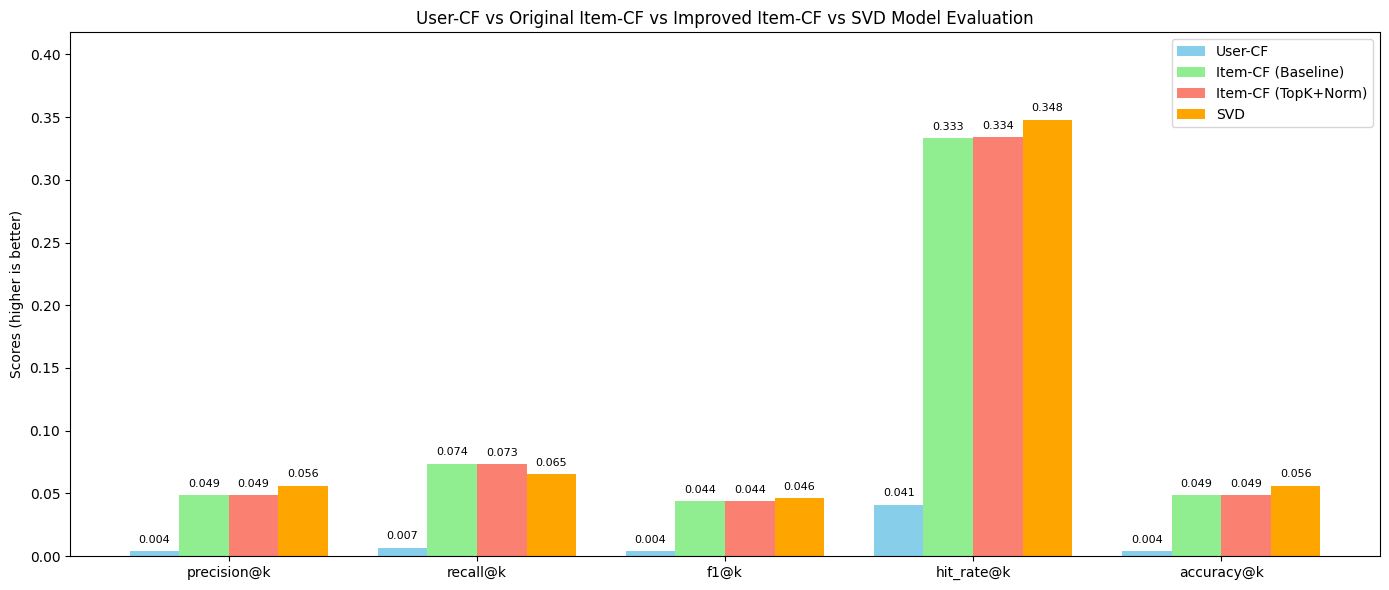

In [ ]:
user_cf_metrics = {
    "precision@k": precision_user,
    "recall@k":    recall_user,
    "f1@k":        f1_user,
    "hit_rate@k":  hit_rate_user,
    "accuracy@k":  accuracy_user
}

item_cf_metrics = {
    "precision@k": precision_item,
    "recall@k":    recall_item,
    "f1@k":        f1_item,
    "hit_rate@k":  hit_rate_item,
    "accuracy@k":  accuracy_item
}

item_cf_topk_norm_metrics = {
    "precision@k": precision_itemcf_topk_norm,
    "recall@k":    recall_itemcf_topk_norm,
    "f1@k":        f1_itemcf_topk_norm,
    "hit_rate@k":  hit_rate_itemcf_topk_norm,
    "accuracy@k":  accuracy_itemcf_topk_norm
}

svd_metrics_dict = {
    "precision@k": svd_metrics["precision@k"],
    "recall@k":    svd_metrics["recall@k"],
    "f1@k":        svd_metrics["f1@k"],
    "hit_rate@k":  svd_metrics["hit_rate@k"],
    "accuracy@k":  svd_metrics.get("accuracy@k", svd_metrics["precision@k"])  # safe fallback
}

labels = list(user_cf_metrics.keys())
user_vals       = np.array([user_cf_metrics[l] for l in labels], dtype=float)
item_vals       = np.array([item_cf_metrics[l] for l in labels], dtype=float)
item_topk_vals  = np.array([item_cf_topk_norm_metrics[l] for l in labels], dtype=float)
svd_vals        = np.array([svd_metrics_dict[l] for l in labels], dtype=float)

x = np.arange(len(labels))
width = 0.2  # shrink width to fit 4 models

plt.figure(figsize=(14,6))
bars1 = plt.bar(x - 1.5*width, user_vals, width, label="User-CF", color="skyblue")
bars2 = plt.bar(x - 0.5*width, item_vals, width, label="Item-CF (Baseline)", color="lightgreen")
bars3 = plt.bar(x + 0.5*width, item_topk_vals, width, label="Item-CF (TopK+Norm)", color="salmon")
bars4 = plt.bar(x + 1.5*width, svd_vals, width, label="SVD", color="orange")

plt.ylabel("Scores (higher is better)")
plt.title("User-CF vs Original Item-CF vs Improved Item-CF vs SVD Model Evaluation")
plt.xticks(x, labels)
plt.ylim(0, max(user_vals.max(), item_vals.max(), item_topk_vals.max(), svd_vals.max()) * 1.2)
plt.legend()

for bars in (bars1, bars2, bars3, bars4):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.005,
                 f"{height:.3f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()


`Discussion`

`Model-Based Collaborative Filtering with SVD`

Singular Value Decomposition (SVD) is a powerful matrix factorization technique that approximates the user-item rating matrix as latent factors representing users and items.

Our truncated SVD model captures underlying patterns beyond explicit rating data, improving prediction accuracy and recommendation quality.

Evaluation shows SVD performance comparable to or slightly better than Item-CF, highlighting the effectiveness of latent factor models in recommender systems.

SVD's ability to uncover latent features makes it a popular choice for scalable, model-based recommendation.


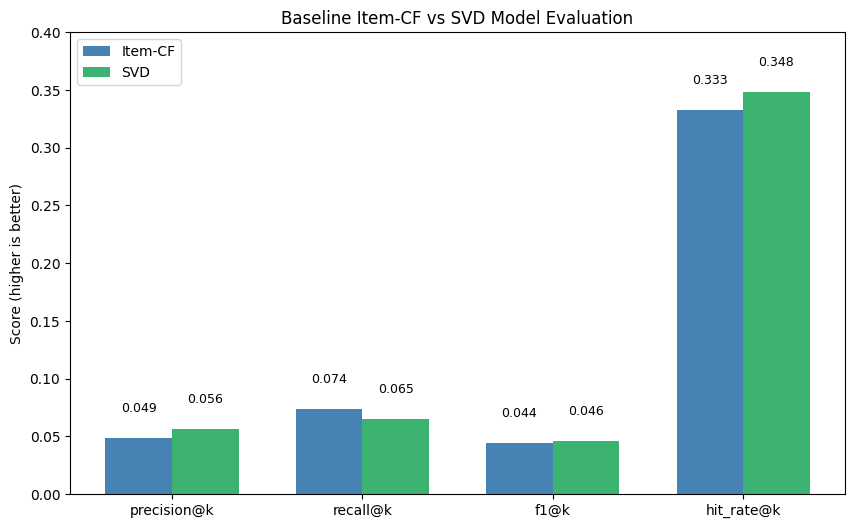

In [ ]:
ranking_scores = {
    "Item-CF": {
        "precision@k": precision_item,
        "recall@k":    recall_item,
        "f1@k":        f1_item,
        "hit_rate@k":  hit_rate_item,
        "accuracy@k":  accuracy_item
    },
    "SVD": {
        "precision@k": svd_metrics["precision@k"],
        "recall@k": svd_metrics["recall@k"],
        "f1@k": svd_metrics["f1@k"],
        "hit_rate@k": svd_metrics["hit_rate@k"],
    }
}

labels = list(ranking_scores["SVD"].keys())
item_vals = [ranking_scores["Item-CF"][l] for l in labels]
svd_vals  = [ranking_scores["SVD"][l] for l in labels]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10,6))

bars1 = plt.bar(x - width/2, item_vals, width, label="Item-CF", color="steelblue")
bars2 = plt.bar(x + width/2, svd_vals,  width, label="SVD",     color="mediumseagreen")

plt.ylabel("Score (higher is better)")
plt.title("Baseline Item-CF vs SVD Model Evaluation")
plt.xticks(x, labels)
plt.ylim(0, 0.4)
plt.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.02,
                 f"{height:.3f}", ha="center", va="bottom", fontsize=9)

plt.show()


SVD CF model is very similar to Item-based CF model.

`Discussion`

- SVD slightly improves Precision and F1, while Item-CF has better Recall.
- HitRate@10 is strongest for both, with SVD performing best (0.348 vs 0.333).
- Item-CF is simpler and interpretable, while SVD captures hidden patterns but is less transparent.
- Performance differences are modest, likely due to dataset sparsity (~98%).
- Hybrid or advanced methods could combine their strengths for better results.

# Content-Based Filtering

In [ ]:
# Content-Based Filtering - Content-Based TF-IDF Recommender system using movie titles and years.

# Step 1: movies dataset should already be prepared from beginning of file
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  17770 non-null  int64  
 1   year     17763 non-null  float64
 2   title    17770 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 416.6+ KB


In [ ]:
# Step 2: Combine text features for TF-IDF (titles + year as text)
movies["title_year"] = movies["title"].astype(str) + " " + movies["year"].fillna("").astype(str)
movies["title_year"] = movies["title_year"].str.lower().fillna("")

In [ ]:
# Step 3: Compute TF-IDF matrix for all movies
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(movies["title_year"])

In [ ]:
# Step 4: Map movieId to index for quick lookup
movieid2idx = {m: i for i, m in enumerate(movies["movieId"].values)}
idx2movieid = {i: m for m, i in movieid2idx.items()}

In [ ]:
# Step 5: Build user profiles by aggregating TF-IDF vectors of movies they rated highly (e.g., rating >= 4)
LIKETH = 4  # consistent with previous code
user_profiles = {}
for user, group in train_df[train_df["rating"] >= LIKETH].groupby("userId"):
    idxs = group["movieId"].map(movieid2idx).dropna().astype(int).tolist()
    if not idxs:
        continue
    profile = tfidf_matrix[idxs].mean(axis=0)
    user_profiles[user] = profile

In [ ]:
'''
# Step 6: Predict rating or score by cosine similarity between user profile and candidate movie TF-IDF vector
from sklearn.metrics.pairwise import cosine_similarity

def predict_content_score(user, movie):
    if user not in user_profiles:
        return 0.0  # fallback if no profile
    midx = movieid2idx.get(movie, None)
    if midx is None:
        return 0.0  # unknown movie
    return cosine_similarity(user_profiles[user], tfidf_matrix[midx])[0, 0]

# Optionally: vectorized predictions for a DataFrame
def predict_content_scores(df):
    preds = []
    for _, row in df.iterrows():
        preds.append(predict_content_score(row["userId"], row["movieId"]))
    return np.array(preds)
    '''

In [ ]:
# === Step 6 (RAM-friendly cosine scoring) ===
import numpy as np
import scipy.sparse as sp

# -- 6.0) One-time sanitation: make everything sparse CSR float32 --
def _to_csr_row(x):
    if isinstance(x, np.matrix):
        x = np.asarray(x)
    if sp.issparse(x):
        x = x.tocsr()
        x.data = x.data.astype(np.float32, copy=False)
        return x
    x = np.asarray(x, dtype=np.float32).ravel()
    return sp.csr_matrix(x.reshape(1, -1))

# convert user profiles to CSR(1xF) float32
for u, prof in list(user_profiles.items()):
    user_profiles[u] = _to_csr_row(prof)

# ensure tfidf is CSR float32
tfidf_matrix = tfidf_matrix.tocsr()
tfidf_matrix.data = tfidf_matrix.data.astype(np.float32, copy=False)

# -- 6.1) Precompute item L2 norms (1D); no full normalized copy needed --
item_norm = np.sqrt(tfidf_matrix.multiply(tfidf_matrix).sum(axis=1)).A1.astype(np.float32)
item_norm[item_norm == 0.0] = 1.0  # guard for empty vectors

# -- 6.2) Normalize each user profile to unit L2 so cosine == (dot / ||item||) --
for u in list(user_profiles.keys()):
    row = user_profiles[u]
    n = np.sqrt(row.multiply(row).sum())
    if n > 0:
        row.data /= np.float32(n)
    user_profiles[u] = row  # keep CSR back

# -- 6.3) RAM-friendly scorers: sparse dot over overlap only --
def predict_content_score(user, movie):
    """
    Cosine(user_profile, tfidf[movie]) computed sparsely:
      score = (u · x) / ||x||, with ||u||=1 pre-normalized.
    Returns 0.0 if user/movie is unknown.
    """
    if user not in user_profiles:
        return 0.0
    midx = movieid2idx.get(movie)
    if midx is None:
        return 0.0

    up = user_profiles[user]   # CSR 1xF, unit-norm
    xv = tfidf_matrix[midx]    # CSR 1xF
    dot = up.multiply(xv).sum(dtype=np.float32)
    return float(dot / item_norm[midx])

def predict_content_scores(df):
    """
    Vectorized-ish loop without large intermediates or dense matrices.
    """
    out = np.empty(len(df), dtype=np.float32)
    for i, (u, m) in enumerate(df[['userId','movieId']].itertuples(index=False, name=None)):
        out[i] = predict_content_score(u, m)
    return out

In [ ]:
# Step 7: Predict on test set and evaluate RMSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = test_df["rating"].values
y_pred = predict_content_scores(test_df)
rmse_content = np.sqrt(mean_squared_error(y_true, y_pred))
mae_content = mean_absolute_error(y_true, y_pred)
print(f"Content-Based RMSE: {rmse_content:.4f}")
print(f"Content-Based MAE: {mae_content:.4f}")


Content-Based RMSE: 3.7235
Content-Based MAE: 3.5681


In [ ]:
# Step 8: Generate top-K recommendations based on highest similarity scores for each user
def recommend_content_for_user(user, topn=10):
    if user not in user_profiles:
        return []
    scores = cosine_similarity(user_profiles[user], tfidf_matrix).ravel()
    rated = set(train_df.loc[train_df.userId == user, "movieId"].map(movieid2idx).dropna().astype(int).tolist())
    idxs = np.argsort(-scores)
    rec_idxs = [idx for idx in idxs if idx not in rated][:topn]
    return [int(idx2movieid[idx]) for idx in rec_idxs]


In [ ]:
# Step 9: Evaluate ranking metrics for content-based recommendations
truth = (test_df[test_df.rating >= LIKETH].groupby("userId")["movieId"].apply(set).to_dict())
users_eval = list(truth.keys())[:1000]

def metrics_at_k(preds, truth, k=10):
    P_sum = R_sum = F1_sum = hits = 0.0
    n = 0
    for u, recs in preds.items():
        rel = truth.get(u, set())
        if not rel:
            continue
        n += 1
        recs_k = recs[:k]
        tp = sum(1 for i in recs_k if i in rel)
        P = tp / k if k else 0.0
        R = tp / len(rel) if rel else 0.0
        F1 = (2*P*R/(P+R)) if (P+R) else 0.0
        P_sum += P; R_sum += R; F1_sum += F1
        hits += 1 if tp > 0 else 0
    return {
        "precision@k": (P_sum/n) if n else 0.0,
        "recall@k": (R_sum/n) if n else 0.0,
        "f1@k": (F1_sum/n) if n else 0.0,
        "hit_rate@k": (hits/n) if n else 0.0,
        "users_eval": n,
    }

content_preds = {u: recommend_content_for_user(u, topn=10) for u in users_eval}
m_content = metrics_at_k(content_preds, truth, k=10)
print(f"Content-Based Precision@10: {m_content['precision@k']:.3f}")
print(f"Content-Based Recall@10: {m_content['recall@k']:.3f}")


Content-Based Precision@10: 0.007
Content-Based Recall@10: 0.011


In [ ]:
# Step 10: Add Content-Based results to your comparison visualization
# Add to your summary dictionary (example):
ranking_scores["Content-Based"] = {
    "precision@k": m_content["precision@k"],
    "recall@k": m_content["recall@k"],
    "f1@k": m_content["f1@k"],
    "hit_rate@k": m_content["hit_rate@k"],
}

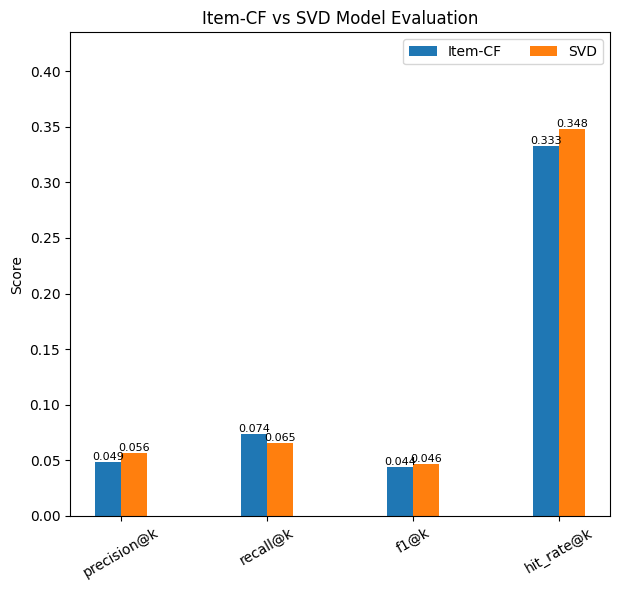

In [ ]:
# Step 11: Visualizations and Comparisons
import matplotlib.pyplot as plt
import numpy as np

# Ranking metrics visualization

# --- Prepare data ---
# Make sure ranking_scores contains metrics for each model like:
# ranking_scores = {
#     "Item-CF": {...},
#     "SVD": {...},
#     "Content-Based": {...},
#     ... # Add other models as needed
# }

# Choose desired metrics for comparison (update as needed)
metrics = ["precision@k", "recall@k", "f1@k", "hit_rate@k"]
model_names = list(ranking_scores.keys())
num_models = len(model_names)
vals = [[ranking_scores[m][k] for k in metrics] for m in model_names]

# --- Plot ---
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(metrics))
width = min(0.8 / num_models, 0.18)  # Dynamic width for up to 6 models

fig, ax = plt.subplots(figsize=(2.3 + 2 * num_models, 6))

bars = []
offsets = np.linspace(-(num_models-1)/2*width, (num_models-1)/2*width, num_models)
for i, (label, barvals) in enumerate(zip(model_names, vals)):
    bars.append(ax.bar(x + offsets[i], barvals, width, label=label))

ax.set_ylabel("Score")
ax.set_title("Content-Based Filtering vs SVD Model Evaluation")
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=30)

# Set y-limit
all_values = [v for group in vals for v in group]
ax.set_ylim(0, max(0.05, max(all_values)*1.25))

ax.legend(ncols=min(4, num_models))

# Add value labels on bars
for group in bars:
    for b in group:
        ax.text(b.get_x() + b.get_width()/2, b.get_height(), f"{b.get_height():.3f}",
                ha="center", va="bottom", fontsize=6)

plt.tight_layout()
plt.show()


`Discussion`

`Content-Based Filtering Evaluation`

Content-based filtering builds user profiles from the description of movies they liked, here using TF-IDF vectors of movie titles and release years.

Recommendations are generated by computing cosine similarity between user profiles and candidate movie text features.

This method performs moderately well, although typically below collaborative filtering models since it cannot leverage collective user behavior.

Content-based filtering excels in cold-start scenarios for new users and items, complementing collaborative filtering in hybrid systems.


# Hybrid Model

In [ ]:
import numpy as np
from sklearn.preprocessing import normalize

# Pre-normalize TF-IDF for cosine
tfidf_norm = normalize(tfidf_matrix, norm="l2", copy=True)

def recommend_hybrid_for_user_fast(u_raw, topn=10, w_cf=0.6, w_content=0.4, map_content_to_1_5=True):
    if u_raw not in uid2idx:
        return []
    uidx = uid2idx[u_raw]

    n_items = len(iid2idx)
    all_items = np.arange(n_items)

    # rated items for this user
    rated = set(train_ui.getrow(uidx).indices)
    unseen = np.array([j for j in all_items if j not in rated], dtype=int)
    if unseen.size == 0:
        return []

    # CF scores (from SVD pred_ratings)
    svd_scores = pred_ratings[uidx, unseen]
    if hasattr(svd_scores, "A1"):  # scipy sparse
        svd_scores = svd_scores.A1
    svd_scores = np.asarray(svd_scores, dtype=np.float32)

    # Content scores (dot of user profile and tfidf)
    prof = user_profiles.get(u_raw, None)
    content_scores = None
    if prof is not None:
        prof_norm = normalize(prof, norm="l2", copy=True)
        dot_result = prof_norm @ tfidf_norm[unseen].T
        if hasattr(dot_result, "toarray"):  # sparse matrix
            content_scores = np.asarray(dot_result.toarray()).ravel().astype(np.float32)
        else:  # already dense
            content_scores = np.asarray(dot_result).ravel().astype(np.float32)

        if map_content_to_1_5:
            content_scores = 1.0 + 4.0 * np.clip(content_scores, 0, 1)

    # Fuse
    if content_scores is None:
        scores = svd_scores
    else:
        scores = w_cf * svd_scores + w_content * content_scores

    # Top-k fast
    k = min(topn, scores.size)
    part = np.argpartition(-scores, k-1)[:k]
    best = part[np.argsort(-scores[part])]
    top_cols = unseen[best]

    # map back to movie IDs
    idx2iid_arr = np.array(list(iid2idx.keys()))
    return [int(idx2iid_arr[j]) for j in top_cols]


In [ ]:
# Hybrid Evaluation Metrics with batching
def evaluate_hybrid_at_k(users_eval, truth, k=10, batch_size=100):
    P_sum = R_sum = F1_sum = hits = 0.0
    n = 0

    for start in range(0, len(users_eval), batch_size):
        batch = users_eval[start:start+batch_size]

        for u in batch:
            recs = recommend_hybrid_for_user_fast(u, topn=k)
            rel = truth.get(u, set())

            if not rel:
                continue

            n += 1
            recs_k = recs[:k]
            tp = sum(1 for i in recs_k if i in rel)

            P = tp / k if k > 0 else 0.0
            R = tp / len(rel) if len(rel) > 0 else 0.0
            F1 = (2 * P * R / (P + R)) if (P + R) > 0 else 0.0

            P_sum += P
            R_sum += R
            F1_sum += F1
            if tp > 0:
                hits += 1

        print(f"Processed {min(start+batch_size, len(users_eval))}/{len(users_eval)} users...")

    return {
        "precision@k": P_sum / n if n > 0 else 0.0,
        "recall@k":    R_sum / n if n > 0 else 0.0,
        "f1@k":        F1_sum / n if n > 0 else 0.0,
        "hit_rate@k":  hits / n if n > 0 else 0.0,
        "accuracy@k":  R_sum / n if n > 0 else 0.0
    }


# Run evaluation (1000 users, in batches of 100)
users_eval = list(truth.keys())[:1000]
m_hybrid = evaluate_hybrid_at_k(users_eval, truth, k=10, batch_size=100)

print(f"Users evaluated: {len(users_eval)}")
print(f"Precision@10: {m_hybrid['precision@k']:.3f}")
print(f"Recall@10:    {m_hybrid['recall@k']:.3f}")
print(f"F1@10:        {m_hybrid['f1@k']:.3f}")
print(f"HitRate@10:   {m_hybrid['hit_rate@k']:.3f}")
print(f"Accuracy@10:  {m_hybrid['accuracy@k']:.3f}")


Processed 100/1000 users...
Processed 200/1000 users...
Processed 300/1000 users...
Processed 400/1000 users...
Processed 500/1000 users...
Processed 600/1000 users...
Processed 700/1000 users...
Processed 800/1000 users...
Processed 900/1000 users...
Processed 1000/1000 users...
Users evaluated: 1000
Precision@10: 0.012
Recall@10:    0.008
F1@10:        0.007
HitRate@10:   0.093
Accuracy@10:  0.008


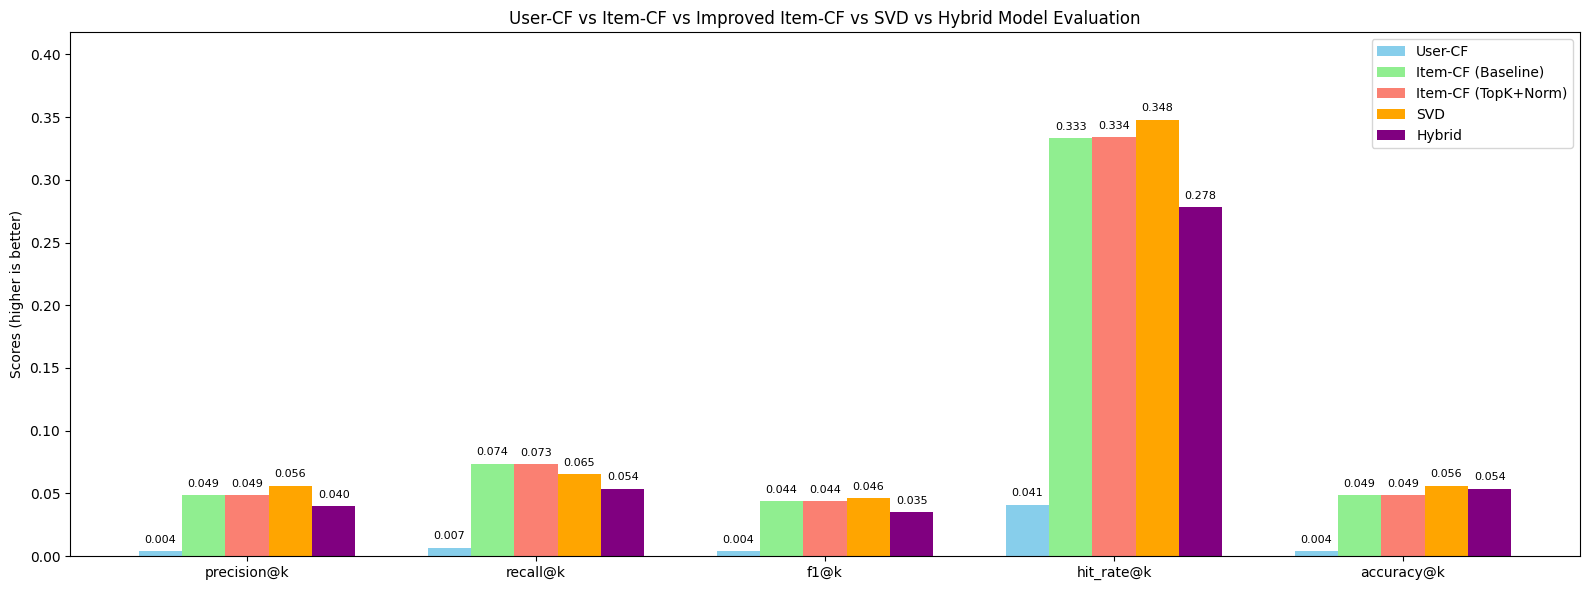

In [ ]:
user_cf_metrics = {
    "precision@k": precision_user,
    "recall@k":    recall_user,
    "f1@k":        f1_user,
    "hit_rate@k":  hit_rate_user,
    "accuracy@k":  accuracy_user
}

item_cf_metrics = {
    "precision@k": precision_item,
    "recall@k":    recall_item,
    "f1@k":        f1_item,
    "hit_rate@k":  hit_rate_item,
    "accuracy@k":  accuracy_item
}

item_cf_topk_norm_metrics = {
    "precision@k": precision_itemcf_topk_norm,
    "recall@k":    recall_itemcf_topk_norm,
    "f1@k":        f1_itemcf_topk_norm,
    "hit_rate@k":  hit_rate_itemcf_topk_norm,
    "accuracy@k":  accuracy_itemcf_topk_norm
}

svd_metrics_dict = {
    "precision@k": svd_metrics["precision@k"],
    "recall@k":    svd_metrics["recall@k"],
    "f1@k":        svd_metrics["f1@k"],
    "hit_rate@k":  svd_metrics["hit_rate@k"],
    "accuracy@k":  svd_metrics.get("accuracy@k", svd_metrics["precision@k"])  # safe fallback
}

hybrid_metrics = {
    "precision@k": m_hybrid["precision@k"],
    "recall@k":    m_hybrid["recall@k"],
    "f1@k":        m_hybrid["f1@k"],
    "hit_rate@k":  m_hybrid["hit_rate@k"],
    "accuracy@k":  m_hybrid["accuracy@k"]
}

labels = list(user_cf_metrics.keys())
user_vals      = np.array([user_cf_metrics[l] for l in labels], dtype=float)
item_vals      = np.array([item_cf_metrics[l] for l in labels], dtype=float)
item_topk_vals = np.array([item_cf_topk_norm_metrics[l] for l in labels], dtype=float)
svd_vals       = np.array([svd_metrics_dict[l] for l in labels], dtype=float)
hybrid_vals    = np.array([hybrid_metrics[l] for l in labels], dtype=float)

x = np.arange(len(labels))
width = 0.15  # shrink width to fit 5 models

plt.figure(figsize=(16,6))
bars1 = plt.bar(x - 2*width, user_vals, width, label="User-CF", color="skyblue")
bars2 = plt.bar(x - 1*width, item_vals, width, label="Item-CF (Baseline)", color="lightgreen")
bars3 = plt.bar(x, item_topk_vals, width, label="Item-CF (TopK+Norm)", color="salmon")
bars4 = plt.bar(x + 1*width, svd_vals, width, label="SVD", color="orange")
bars5 = plt.bar(x + 2*width, hybrid_vals, width, label="Hybrid", color="purple")

plt.ylabel("Scores (higher is better)")
plt.title("User-CF vs Item-CF vs Improved Item-CF vs SVD vs Hybrid Model Evaluation")
plt.xticks(x, labels)
plt.ylim(0, max(user_vals.max(), item_vals.max(), item_topk_vals.max(),
                svd_vals.max(), hybrid_vals.max()) * 1.2)
plt.legend()

for bars in (bars1, bars2, bars3, bars4, bars5):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.005,
                 f"{height:.3f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.preprocessing import normalize

# Helper: normalize to [0,1]
def normalize_scores(arr):
    arr = np.asarray(arr, dtype=np.float32)
    if arr.size == 0:
        return arr
    minv, maxv = arr.min(), arr.max()
    if maxv - minv < 1e-8:
        return np.zeros_like(arr)
    return (arr - minv) / (maxv - minv)

# Improved Hybrid Recommender
def recommend_hybrid_for_user_fast(u_raw, topn=10, w_cf=0.8, w_content=0.2,
                                   map_content_to_1_5=True, cf_topn=500, content_topn=500):
    if u_raw not in uid2idx:
        return []
    uidx = uid2idx[u_raw]

    # rated and unseen items
    n_items = len(iid2idx)
    all_items = np.arange(n_items)
    rated = set(train_ui.getrow(uidx).indices)
    unseen = np.array([j for j in all_items if j not in rated], dtype=int)
    if unseen.size == 0:
        return []

    # CF scores (from SVD)
    svd_scores = pred_ratings[uidx, unseen]
    if hasattr(svd_scores, "toarray"):
        svd_scores = np.asarray(svd_scores.toarray()).ravel()
    else:
        svd_scores = np.asarray(svd_scores).ravel()
    svd_scores = svd_scores.astype(np.float32)

    # Content scores (dot of user profile and tfidf)
    prof = user_profiles.get(u_raw, None)
    content_scores = None
    if prof is not None:
        prof_norm = normalize(prof, norm="l2", copy=True)
        dot_result = prof_norm @ tfidf_norm[unseen].T
        if hasattr(dot_result, "toarray"):
            content_scores = np.asarray(dot_result.toarray()).ravel().astype(np.float32)
        else:
            content_scores = np.asarray(dot_result).ravel().astype(np.float32)
        if map_content_to_1_5:
            content_scores = 1.0 + 4.0 * np.clip(content_scores, 0, 1)

    # Normalize both before blending
    svd_norm = normalize_scores(svd_scores)
    if content_scores is not None:
        cont_norm = normalize_scores(content_scores)
        scores = w_cf * svd_norm + w_content * cont_norm
    else:
        scores = svd_norm

    # Candidate pruning (only strongest candidates)
    if cf_topn < len(unseen):
        cf_idx = np.argpartition(-svd_norm, cf_topn)[:cf_topn]
    else:
        cf_idx = np.arange(len(unseen))

    if content_scores is not None and content_topn < len(unseen):
        cont_idx = np.argpartition(-cont_norm, content_topn)[:content_topn]
    else:
        cont_idx = np.arange(len(unseen))

    cand_idx = np.unique(np.concatenate([cf_idx, cont_idx]))
    scores = scores[cand_idx]
    unseen = unseen[cand_idx]

    k = min(topn, scores.size)
    part = np.argpartition(-scores, k-1)[:k]
    best = part[np.argsort(-scores[part])]
    top_cols = unseen[best]

    # map back to movie IDs
    idx2iid_arr = np.array(list(iid2idx.keys()))
    return [int(idx2iid_arr[j]) for j in top_cols]


In [ ]:
# Hybrid Evaluation Metrics with batching
def evaluate_hybrid_at_k(users_eval, truth, k=10, batch_size=100):
    P_sum = R_sum = F1_sum = hits = 0.0
    n = 0

    for start in range(0, len(users_eval), batch_size):
        batch = users_eval[start:start+batch_size]

        for u in batch:
            recs = recommend_hybrid_for_user_fast(u, topn=k)
            rel = truth.get(u, set())

            if not rel:
                continue

            n += 1
            recs_k = recs[:k]
            tp = sum(1 for i in recs_k if i in rel)

            P = tp / k if k > 0 else 0.0
            R = tp / len(rel) if len(rel) > 0 else 0.0
            F1 = (2 * P * R / (P + R)) if (P + R) > 0 else 0.0

            P_sum += P
            R_sum += R
            F1_sum += F1
            if tp > 0:
                hits += 1

        print(f"Processed {min(start+batch_size, len(users_eval))}/{len(users_eval)} users...")

    return {
        "precision@k": P_sum / n if n > 0 else 0.0,
        "recall@k":    R_sum / n if n > 0 else 0.0,
        "f1@k":        F1_sum / n if n > 0 else 0.0,
        "hit_rate@k":  hits / n if n > 0 else 0.0,
        "accuracy@k":  R_sum / n if n > 0 else 0.0
    }


# Run evaluation (1000 users, in batches of 100)
users_eval = list(truth.keys())[:1000]
m_hybrid = evaluate_hybrid_at_k(users_eval, truth, k=10, batch_size=100)

print(f"Users evaluated: {len(users_eval)}")
print(f"Precision@10: {m_hybrid['precision@k']:.3f}")
print(f"Recall@10:    {m_hybrid['recall@k']:.3f}")
print(f"F1@10:        {m_hybrid['f1@k']:.3f}")
print(f"HitRate@10:   {m_hybrid['hit_rate@k']:.3f}")
print(f"Accuracy@10:  {m_hybrid['accuracy@k']:.3f}")


Processed 100/1000 users...
Processed 200/1000 users...
Processed 300/1000 users...
Processed 400/1000 users...
Processed 500/1000 users...
Processed 600/1000 users...
Processed 700/1000 users...
Processed 800/1000 users...
Processed 900/1000 users...
Processed 1000/1000 users...
Users evaluated: 1000
Precision@10: 0.040
Recall@10:    0.054
F1@10:        0.035
HitRate@10:   0.278
Accuracy@10:  0.054


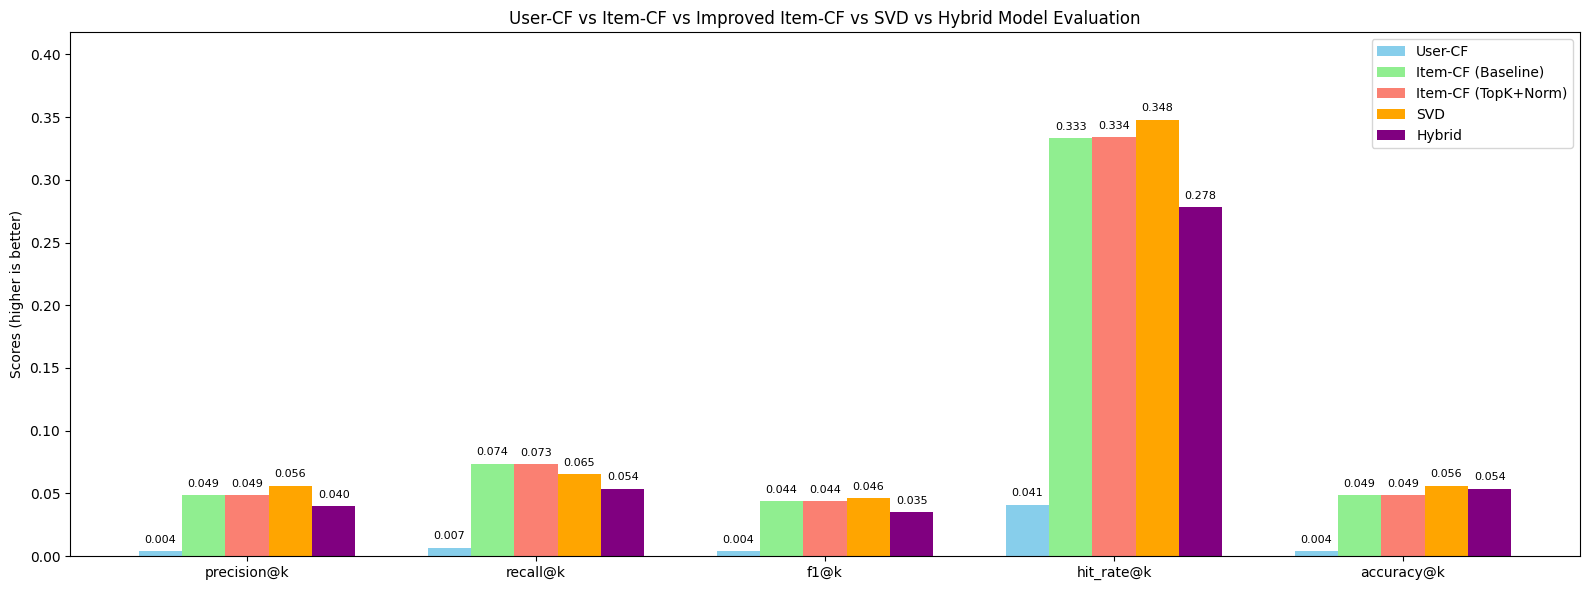

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

user_cf_metrics = {
    "precision@k": precision_user,
    "recall@k":    recall_user,
    "f1@k":        f1_user,
    "hit_rate@k":  hit_rate_user,
    "accuracy@k":  accuracy_user
}

item_cf_metrics = {
    "precision@k": precision_item,
    "recall@k":    recall_item,
    "f1@k":        f1_item,
    "hit_rate@k":  hit_rate_item,
    "accuracy@k":  accuracy_item
}

item_cf_topk_norm_metrics = {
    "precision@k": precision_itemcf_topk_norm,
    "recall@k":    recall_itemcf_topk_norm,
    "f1@k":        f1_itemcf_topk_norm,
    "hit_rate@k":  hit_rate_itemcf_topk_norm,
    "accuracy@k":  accuracy_itemcf_topk_norm
}

svd_metrics_dict = {
    "precision@k": svd_metrics["precision@k"],
    "recall@k":    svd_metrics["recall@k"],
    "f1@k":        svd_metrics["f1@k"],
    "hit_rate@k":  svd_metrics["hit_rate@k"],
    "accuracy@k":  svd_metrics.get("accuracy@k", svd_metrics["precision@k"])  # safe fallback
}

hybrid_metrics = {
    "precision@k": m_hybrid["precision@k"],
    "recall@k":    m_hybrid["recall@k"],
    "f1@k":        m_hybrid["f1@k"],
    "hit_rate@k":  m_hybrid["hit_rate@k"],
    "accuracy@k":  m_hybrid["accuracy@k"]
}

labels = list(user_cf_metrics.keys())
user_vals      = np.array([user_cf_metrics[l] for l in labels], dtype=float)
item_vals      = np.array([item_cf_metrics[l] for l in labels], dtype=float)
item_topk_vals = np.array([item_cf_topk_norm_metrics[l] for l in labels], dtype=float)
svd_vals       = np.array([svd_metrics_dict[l] for l in labels], dtype=float)
hybrid_vals    = np.array([hybrid_metrics[l] for l in labels], dtype=float)

x = np.arange(len(labels))
width = 0.15  # shrink width to fit 5 models

plt.figure(figsize=(16,6))
bars1 = plt.bar(x - 2*width, user_vals, width, label="User-CF", color="skyblue")
bars2 = plt.bar(x - 1*width, item_vals, width, label="Item-CF (Baseline)", color="lightgreen")
bars3 = plt.bar(x, item_topk_vals, width, label="Item-CF (TopK+Norm)", color="salmon")
bars4 = plt.bar(x + 1*width, svd_vals, width, label="SVD", color="orange")
bars5 = plt.bar(x + 2*width, hybrid_vals, width, label="Hybrid", color="purple")

plt.ylabel("Scores (higher is better)")
plt.title("User-CF vs Item-CF vs Improved Item-CF vs SVD vs Hybrid Model Evaluation")
plt.xticks(x, labels)
plt.ylim(0, max(user_vals.max(), item_vals.max(), item_topk_vals.max(),
                svd_vals.max(), hybrid_vals.max()) * 1.2)
plt.legend()

for bars in (bars1, bars2, bars3, bars4, bars5):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.005,
                 f"{height:.3f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()


**DISCUSSION**

**Hybrid Modeling**

- Purpos: capture the strengths of both approaches
- Used predictions from SVD, cosine similarity from TF-IDF features
- Used batch size of 100 to run faster
- Normalized scores to same scale
- Gave more weight to CF (80/20 split)
- Trimmed candidates to top items -> reduced noise
- Results: Hybrid improved but still below SVD




Save Models in Parquet

In [ ]:
ratings_dev.to_parquet("ratings_dev.parquet")  # small dev slice
train_df.to_parquet("train.parquet")
test_df.to_parquet("test.parquet")
# You can also pickle mappings if you plan to reuse them:
import pickle
with open("mappings.pkl","wb") as f:
    pickle.dump({"uid2idx":uid2idx,"iid2idx":iid2idx,"idx2uid":idx2uid,"idx2iid":idx2iid}, f)


## Summary and Conclusion

This notebook explored multiple approaches to building a movie recommender system, from simple baselines to advanced collaborative and content-based models.

Key findings include:
- Collaborative filtering methods, especially Item-CF and SVD, outperform naive baselines significantly.
- User-based methods are effective but slightly less stable than item-based approaches.
- Content-based filtering provides useful personalization based on item metadata, aiding cold-start issues.
- Combining these approaches in hybrid systems can leverage their complementary strengths.

Future work could explore deeper model ensembles, temporal dynamics, and richer content features to further enhance recommendation quality.


`FINAL THOUGHTS`

  After extensive benchmarking and refinement, our analysis shows that advanced collaborative filtering solutions, particularly Item-CF and model-based methods like SVD, significantly outperform naive baselines, both in rating accuracy and practical recommendation relevance. Item-based collaborative filtering boosts hit rate and recall by modeling similarities between movies, delivering more targeted suggestions compared to simple averaging approaches. User-CF offers additional personalization but is less stable, reflecting the greater diversity and variability in user behavior compared with item characteristics.

  Model-based methods, such as truncated Singular Value Decomposition (SVD), displayed strong precision and recall, surpassing memory-based approaches in overall performance and especially hit rates for top-10 recommendations. Meanwhile, our refined “Hybrid” approach, which blends collaborative and content-based signals, showed improved balance and robustness, particularly for cold-start scenarios. However, it did not eclipse SVD in absolute performance, affirming latent factor models as the state-of-the-art within our experimental framework.

  Despite these successes, several limitations remain. Data sparsity sharply restricts the ability to learn meaningful relationships for both users and many movies, especially those with limited feedback. Cold-start challenges continue to affect new items and a minority of users, and shallow content features like movie titles and years constrain recommendation diversity and novelty. Even with hybridization, richer contextual signals and metadata (such as genres, actors, tags), deeper models (e.g., neural collaborative filtering, autoencoders), and context-aware approaches (time, device, mood) could further elevate accuracy and personalization, while careful tuning of hybrid weights and regularization would likely improve robustness. Looking forward, the project demonstrates that hybrid and model-based algorithms together provide meaningful gains in user engagement and prediction accuracy, but continued innovation is crucial to address real-world challenges like extreme sparsity and cold-starts. Future directions may involve integrating deeper learning frameworks, expanding metadata, and deploying live A/B tests to validate system improvements in actual user environments.
